In [542]:
import sys
sys.path.insert(0, '//home/apprenant/PycharmProjects/turnover/')
# On importe les librairies dont on aura besoin pour ce tp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import normalize
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_regression


Quelles sont les variables de leur modèle ? Quel est leur rôle respectif ? Expliquer la construction de variable (si construite) ou le traitement (valeur aberrantes et manquantes pour variables existantes : discrétisation, polynomialisation ?, ...)
Evaluation du modèle : f_statistique, courbe roc, etc
Réponse aux questions 

In [543]:
df_train = pd.read_csv('../data/attrition_train.csv')
df_test = pd.read_csv('../data/attrition_test.csv')

In [544]:
pd.set_option('display.max_columns', None)

In [545]:
df_train.shape

(1100, 35)

F mesure : Rappel : le + important : on veut bien que toutes les personnes souhaitant partir aillent dans le programme pour éviter le turn over
        Précision : Pour limiter le nombre de personnes faux positifs, parce que le programme a un coût et qu'on peut pas se permettre de le faire passer à tout le monde
        
On aurait pu utiliser un rappel en limitant le nombre de places et donc de positif qu'il renverrait

In [546]:
df_train.sample(10)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
793,18,No,Non-Travel,287,Research & Development,5,2,Life Sciences,1,1012,2,Male,73,3,1,Research Scientist,4,Single,1051,13493,1,Y,No,15,3,4,80,0,0,2,3,0,0,0,0
1039,48,No,Travel_Rarely,1108,Research & Development,15,4,Other,1,1576,3,Female,65,3,1,Research Scientist,1,Married,2367,16530,8,Y,No,12,3,4,80,1,10,3,2,8,2,7,6
993,29,No,Travel_Frequently,574,Research & Development,20,1,Medical,1,1852,4,Male,40,3,1,Laboratory Technician,4,Married,3812,7003,1,Y,No,13,3,2,80,0,11,3,4,11,8,3,10
22,25,No,Travel_Rarely,977,Research & Development,2,1,Other,1,1992,4,Male,57,3,1,Laboratory Technician,3,Divorced,3977,7298,6,Y,Yes,19,3,3,80,1,7,2,2,2,2,0,2
446,32,Yes,Travel_Rarely,964,Sales,1,2,Life Sciences,1,1734,1,Male,34,1,2,Sales Executive,2,Single,6735,12147,6,Y,No,15,3,2,80,0,10,2,3,0,0,0,0
424,60,No,Travel_Rarely,422,Research & Development,7,3,Life Sciences,1,549,1,Female,41,3,5,Manager,1,Married,19566,3854,5,Y,No,11,3,4,80,0,33,5,1,29,8,11,10
1026,50,No,Travel_Rarely,804,Research & Development,9,3,Life Sciences,1,1030,1,Male,64,3,1,Laboratory Technician,4,Married,2380,20165,4,Y,No,18,3,2,80,0,8,5,3,1,0,0,0
668,26,No,Travel_Rarely,390,Research & Development,17,4,Medical,1,1718,4,Male,62,1,1,Laboratory Technician,3,Married,2305,6217,1,Y,No,15,3,3,80,3,3,3,4,3,2,0,2
1024,33,No,Travel_Rarely,931,Research & Development,14,3,Medical,1,252,4,Female,72,3,1,Research Scientist,2,Married,2756,4673,1,Y,No,13,3,4,80,1,8,5,3,8,7,1,6
333,41,No,Non-Travel,256,Sales,10,2,Medical,1,1329,3,Male,40,1,2,Sales Executive,2,Single,6151,22074,1,Y,No,13,3,1,80,0,19,4,3,19,2,11,9


In [547]:
from scipy.stats import chi2_contingency
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [548]:
# def conditional_entropy(x,
#                         y,
#                         nan_strategy=_REPLACE,
#                         nan_replace_value=_DEFAULT_REPLACE_VALUE,
#                         log_base: float = math.e):
#     """
#     Calculates the conditional entropy of x given y: S(x|y)
#     Wikipedia: https://en.wikipedia.org/wiki/Conditional_entropy
#     Parameters:
#     -----------
#     x : list / NumPy ndarray / Pandas Series
#         A sequence of measurements
#     y : list / NumPy ndarray / Pandas Series
#         A sequence of measurements
#     nan_strategy : string, default = 'replace'
#         How to handle missing values: can be either 'drop' to remove samples
#         with missing values, or 'replace' to replace all missing values with
#         the nan_replace_value. Missing values are None and np.nan.
#     nan_replace_value : any, default = 0.0
#         The value used to replace missing values with. Only applicable when
#         nan_strategy is set to 'replace'.
#     log_base: float, default = e
#         specifying base for calculating entropy. Default is base e.
#     Returns:
#     --------
#     float
#     """
#     if nan_strategy == _REPLACE:
#         x, y = replace_nan_with_value(x, y, nan_replace_value)
#     elif nan_strategy == _DROP:
#         x, y = remove_incomplete_samples(x, y)
#     y_counter = Counter(y)
#     xy_counter = Counter(list(zip(x, y)))
#     total_occurrences = sum(y_counter.values())
#     entropy = 0.0
#     for xy in xy_counter.keys():
#         p_xy = xy_counter[xy] / total_occurrences
#         p_y = y_counter[xy[1]] / total_occurrences
#         entropy += p_xy * math.log(p_y / p_xy, log_base)
#     return entropy

# def theils_u(x, y):
#     s_xy = conditional_entropy(x,y)
#     x_counter = Counter(x)
#     total_occurrences = sum(x_counter.values())
#     p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
#     s_x = ss.entropy(p_x)
#     if s_x == 0:
#         return 1
#     else:
#         return (s_x - s_xy) / s_x

In [549]:
def correlation_ratio(categories, measurements):
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0,cat_num):
        cat_measures = measurements[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
    denominator = np.sum(np.power(np.subtract(measurements,y_total_avg),2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = np.sqrt(numerator/denominator)
    return eta

In [550]:
corr_catg={}
for col in df_train.select_dtypes(include=[object]):
    corr_catg[col] = cramers_v(df_train[col], df_train['Attrition'])
print(corr_catg)

{'Attrition': 0.9966456545755022, 'BusinessTravel': 0.14479121536792144, 'Department': 0.08918247718671277, 'EducationField': 0.08894098222835918, 'Gender': 0.0, 'JobRole': 0.24574634326307113, 'MaritalStatus': 0.15509883718355652, 'Over18': nan, 'OverTime': 0.2610973114962042}


In [551]:
corr_num = {}
for col in df_train.select_dtypes(exclude=[object]):
    corr_num[col] = correlation_ratio(df_train['Attrition'], df_train[col])
print(corr_num)

{'Age': 0.14838079680459373, 'DailyRate': 0.05703361812186448, 'DistanceFromHome': 0.06873961072637318, 'Education': 0.028037483049981233, 'EmployeeCount': 0.0, 'EmployeeNumber': 0.012663121768720071, 'EnvironmentSatisfaction': 0.14153752146906665, 'HourlyRate': 0.0219264293784681, 'JobInvolvement': 0.15498463960238565, 'JobLevel': 0.1737084344213059, 'JobSatisfaction': 0.10090106176840333, 'MonthlyIncome': 0.16713811347703894, 'MonthlyRate': 0.025662772736930194, 'NumCompaniesWorked': 0.03451700597270819, 'PercentSalaryHike': 0.004003648769690497, 'PerformanceRating': 0.015867107040797836, 'RelationshipSatisfaction': 0.06858571963480418, 'StandardHours': 0.0, 'StockOptionLevel': 0.13332167095002148, 'TotalWorkingYears': 0.1743927119036858, 'TrainingTimesLastYear': 0.08487651643273413, 'WorkLifeBalance': 0.05595270111112702, 'YearsAtCompany': 0.14802049257233907, 'YearsInCurrentRole': 0.16177173325737748, 'YearsSinceLastPromotion': 0.033724764097131085, 'YearsWithCurrManager': 0.159435

In [552]:
ser_num = pd.Series(corr_num)
ser_catg = pd.Series(corr_catg)

In [553]:
df_train.corr() 

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
Age,1.000000,0.018637,0.009344,0.170530,NaN,-0.024935,0.033625,0.008680,0.024387,0.506205,-0.019643,0.490902,0.031623,0.297198,-0.001005,0.008851,0.038300,NaN,0.030448,0.672519,-0.015841,-0.023525,0.321771,0.217113,0.207753,0.204476
DailyRate,0.018637,1.000000,0.015423,-0.004252,NaN,-0.037602,0.035157,0.007584,0.027075,-0.011294,0.040907,-0.008719,-0.049759,0.037901,0.011438,0.000643,-0.005917,NaN,0.047325,0.010318,-0.003673,-0.050327,-0.029980,0.015291,-0.036480,-0.047130
DistanceFromHome,0.009344,0.015423,1.000000,0.004529,NaN,0.054401,-0.024763,0.024087,0.038924,0.007010,-0.000789,-0.016466,0.035888,-0.034636,0.055251,0.041990,0.011458,NaN,0.048522,0.005076,-0.064677,-0.017711,-0.007356,-0.002095,-0.006738,0.012949
Education,0.170530,-0.004252,0.004529,1.000000,NaN,0.026358,-0.018618,0.023741,0.027211,0.072957,-0.012824,0.064681,-0.050796,0.116996,-0.014733,-0.020190,-0.028079,NaN,0.012832,0.106448,-0.016711,0.009738,0.047681,0.055122,0.038901,0.052975
EmployeeCount,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EmployeeNumber,-0.024935,-0.037602,0.054401,0.026358,NaN,1.000000,0.037149,0.033064,-0.010548,-0.016311,-0.020949,-0.013700,0.023518,-0.009319,-0.009419,-0.022393,-0.046396,NaN,0.065053,-0.041385,0.006836,0.016069,-0.033230,-0.029875,0.005794,-0.025630
EnvironmentSatisfaction,0.033625,0.035157,-0.024763,-0.018618,NaN,0.037149,1.000000,-0.036208,-0.009930,0.022656,-0.008167,0.016831,0.028534,0.011652,-0.052690,-0.048613,0.009597,NaN,0.023250,0.024064,-0.019144,0.023957,-0.014518,0.001401,0.007831,-0.031640
HourlyRate,0.008680,0.007584,0.024087,0.023741,NaN,0.033064,-0.036208,1.000000,0.035286,-0.013841,-0.085824,-0.007479,-0.005908,0.020984,-0.018985,-0.018359,0.009470,NaN,0.059144,-0.003687,-0.007065,0.001508,-0.032437,-0.015631,-0.046590,-0.034753
JobInvolvement,0.024387,0.027075,0.038924,0.027211,NaN,-0.010548,-0.009930,0.035286,1.000000,-0.025888,-0.004044,-0.031782,-0.018666,-0.005780,-0.003852,-0.027266,0.047645,NaN,0.017473,-0.009518,-0.025227,-0.025628,-0.010213,0.015401,-0.004997,0.046894
JobLevel,0.506205,-0.011294,0.007010,0.072957,NaN,-0.016311,0.022656,-0.013841,-0.025888,1.000000,-0.006884,0.950980,0.019948,0.140617,-0.033182,-0.015830,-0.002637,NaN,0.016560,0.782401,-0.022697,0.053752,0.547974,0.413096,0.338757,0.392352


In [554]:
ser_num.sort_values(ascending=False)

TotalWorkingYears           0.174393
JobLevel                    0.173708
MonthlyIncome               0.167138
YearsInCurrentRole          0.161772
YearsWithCurrManager        0.159436
JobInvolvement              0.154985
Age                         0.148381
YearsAtCompany              0.148020
EnvironmentSatisfaction     0.141538
StockOptionLevel            0.133322
JobSatisfaction             0.100901
TrainingTimesLastYear       0.084877
DistanceFromHome            0.068740
RelationshipSatisfaction    0.068586
DailyRate                   0.057034
WorkLifeBalance             0.055953
NumCompaniesWorked          0.034517
YearsSinceLastPromotion     0.033725
Education                   0.028037
MonthlyRate                 0.025663
HourlyRate                  0.021926
PerformanceRating           0.015867
EmployeeNumber              0.012663
PercentSalaryHike           0.004004
StandardHours               0.000000
EmployeeCount               0.000000
dtype: float64

In [555]:
ser_catg.sort_values(ascending=False)

Attrition         0.996646
OverTime          0.261097
JobRole           0.245746
MaritalStatus     0.155099
BusinessTravel    0.144791
Department        0.089182
EducationField    0.088941
Gender            0.000000
Over18                 NaN
dtype: float64

on droppe EmployeeCount qui vaut tout le temps 1, StandardHours qui vaut tout le temps 80, EmployeeNumber qui est un id unique, Over18 : tout le temps Y, 
Que représentent HourlyRate, DailyRate, MonthlyRate ????
Daily Rate = (Monthly Rate X 12) / Total working days in a year. (copié collé)
Hourly Rate = (Daily Rate) / Total working hours in a day (interpreté)

PercentSalaryHike : Hausse de salaire

In [556]:
# df_train['HoursWorkedPerDay'] = df_train['DailyRate']/df_train['HourlyRate']
# df_train['DaysWorkedPerYear'] = df_train['MonthlyRate']*12/df_train['DailyRate']
# df_train['DaysWorkedPerYear2'] = df_train['MonthlyIncome']*12/df_train['DailyRate']
# df_train['WorkingYearsDividedByAge'] = df_train['TotalWorkingYears']/df_train['Age']
# df_train['MonthlyIncomeDividedByAge'] = df_train['MonthlyIncome']/df_train['Age']
# df_train['JobLevelDividedByAge'] = df_train['JobLevel']/df_train['Age']
# df_train['TotalWorkingYears*JobLevel'] = df_train['TotalWorkingYears']*df_train['JobLevel']
# df_train['YearsAtCompany*JobLevel'] = df_train['YearsAtCompany']*df_train['JobLevel']
# df_train['MTotalWorkingYearsByMonthlyIncome'] = df_train['TotalWorkingYears']/df_train['MonthlyIncome']
# df_train['YearsAtCompanyDividedByMonthlyIncome'] = df_train['YearsAtCompany']/df_train['MonthlyIncome']
# df_train['Age-TotalWorkingYears'] = df_train['Age']-df_train['TotalWorkingYears']


In [557]:
# df_test['HoursWorkedPerDay'] = df_test['DailyRate']/df_test['HourlyRate']
# df_test['DaysWorkedPerYear'] = df_test['MonthlyRate']*12/df_test['DailyRate']
# df_test['DaysWorkedPerYear2'] = df_test['MonthlyIncome']*12/df_test['DailyRate']
# df_test['WorkingYearsDividedByAge'] = df_test['TotalWorkingYears']/df_test['Age']
# df_test['MonthlyIncomeDividedByAge'] = df_test['MonthlyIncome']/df_test['Age']
# df_test['JobLevelDividedByAge'] = df_test['JobLevel']/df_test['Age']
# df_test['TotalWorkingYears*JobLevel'] = df_test['TotalWorkingYears']*df_test['JobLevel']
# df_test['YearsAtCompany*JobLevel'] = df_test['YearsAtCompany']*df_test['JobLevel']
# df_test['MTotalWorkingYearsByMonthlyIncome'] = df_test['TotalWorkingYears']/df_test['MonthlyIncome']
# df_test['YearsAtCompanyDividedByMonthlyIncome'] = df_test['YearsAtCompany']/df_test['MonthlyIncome']
# df_test['Age-TotalWorkingYears'] = df_test['Age']-df_test['TotalWorkingYears']

In [558]:
# df_train.sample(10)

In [559]:
df_train.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')

In [560]:
df_train[['DailyRate', 'HourlyRate', 'MonthlyRate']].describe()

,DailyRate,HourlyRate,MonthlyRate
count,1100.000000,1100.000000,1100.000000
mean,804.234545,66.011818,14221.912727
std,405.583238,20.374359,7095.123330
min,102.000000,30.000000,2094.000000
25%,460.500000,48.000000,8049.750000
50%,805.000000,66.000000,14022.500000
75%,1162.000000,84.000000,20344.500000
max,1498.000000,100.000000,26997.000000


In [561]:
df_train['Attrition'].value_counts(normalize=True)

No     0.838182
Yes    0.161818
Name: Attrition, dtype: float64

In [562]:
df_train.describe()


,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1100.000000,1100.000000,1100.000000,1100.000000,1100.0,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.0,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000
mean,36.854545,804.234545,9.301818,2.907273,1.0,1026.404545,2.730909,66.011818,2.707273,2.064545,2.737273,6536.102727,14221.912727,2.733636,15.219091,3.155455,2.697273,80.0,0.785455,11.206364,2.780909,2.780909,7.070000,4.250000,2.186364,4.199091
std,9.039229,405.583238,8.093392,1.012453,0.0,598.712521,1.083564,20.374359,0.731298,1.115862,1.107125,4729.940355,7095.123330,2.533660,3.699863,0.362502,1.084338,0.0,0.848575,7.784761,1.309377,0.706269,6.147387,3.595094,3.234650,3.584848
min,18.000000,102.000000,1.000000,1.000000,1.0,4.000000,1.000000,30.000000,1.000000,1.000000,1.000000,1051.000000,2094.000000,0.000000,11.000000,3.000000,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,460.500000,2.000000,2.000000,1.0,494.750000,2.000000,48.000000,2.000000,1.000000,2.000000,2906.500000,8049.750000,1.000000,12.000000,3.000000,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,805.000000,7.000000,3.000000,1.0,1031.000000,3.000000,66.000000,3.000000,2.000000,3.000000,4938.500000,14022.500000,2.000000,14.000000,3.000000,3.000000,80.0,1.000000,9.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,42.250000,1162.000000,14.000000,4.000000,1.0,1543.250000,4.000000,84.000000,3.000000,3.000000,4.000000,8516.000000,20344.500000,4.000000,18.000000,3.000000,4.000000,80.0,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,60.000000,1498.000000,29.000000,5.000000,1.0,2065.000000,4.000000,100.000000,4.000000,5.000000,4.000000,19999.000000,26997.000000,9.000000,25.000000,4.000000,4.000000,80.0,3.000000,38.000000,6.000000,4.000000,37.000000,18.000000,15.000000,17.000000


In [563]:
print("Nombre de lignes dupliquées")
print(df_train.duplicated().value_counts())
print("\n" + "Nombre de valeurs manquantes")
print(df_train.isnull().sum())

Nombre de lignes dupliquées
False    1100
dtype: int64

Nombre de valeurs manquantes
Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance

In [564]:
print(len(df_train["EmployeeNumber"].unique()))

1100


In [565]:
df_train = df_train[df_train.columns.difference(['EmployeeNumber', 'EmployeeCount', 'StandardHours', 'Over18'])]
df_test = df_test[df_test.columns.difference(['EmployeeNumber', 'EmployeeCount', 'StandardHours', 'Over18', 'index1'])]

In [566]:
df_train['BusinessTravel'].unique()

array(['Travel_Frequently', 'Non-Travel', 'Travel_Rarely'], dtype=object)

In [567]:
df_train[df_train['BusinessTravel'] == 'Travel_Frequently']['Attrition'].value_counts(normalize=True)['Yes']

0.2682926829268293

In [568]:
df_train.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField',
       'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement',
       'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus',
       'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'OverTime',
       'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager'],
      dtype='object')

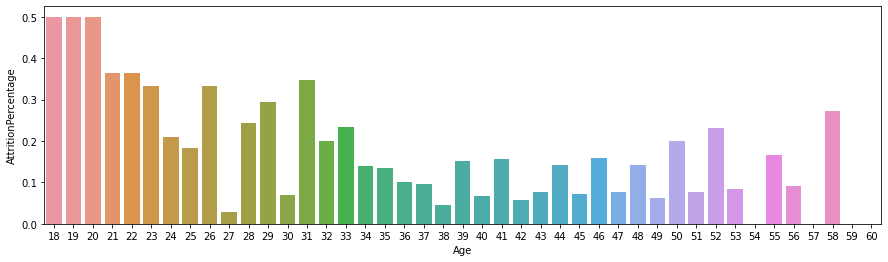

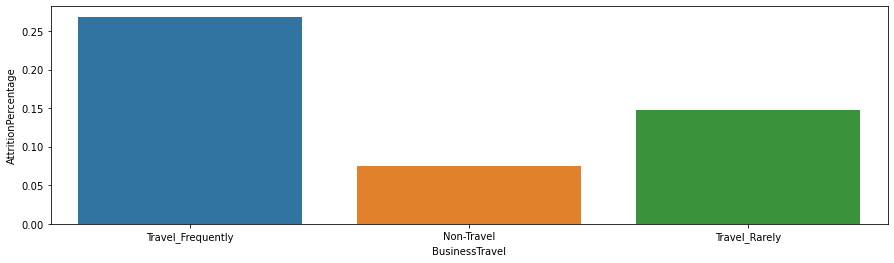

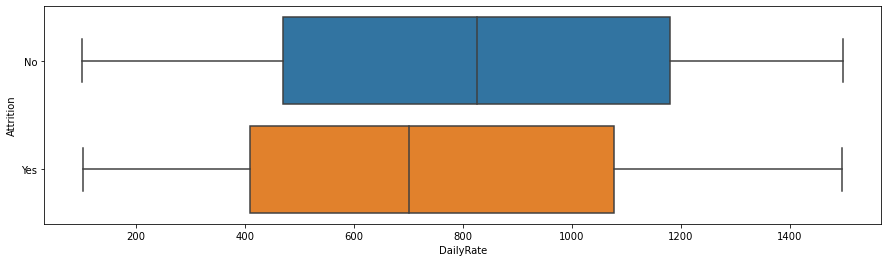

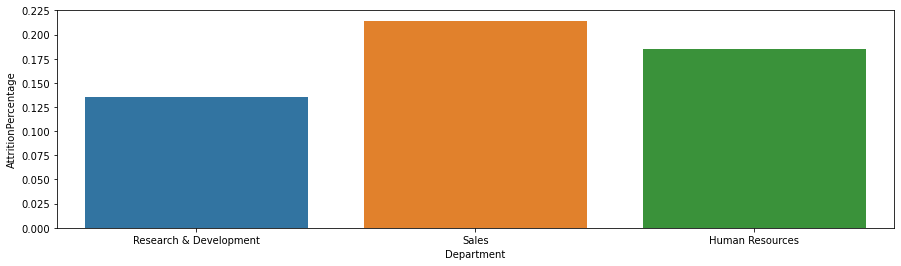

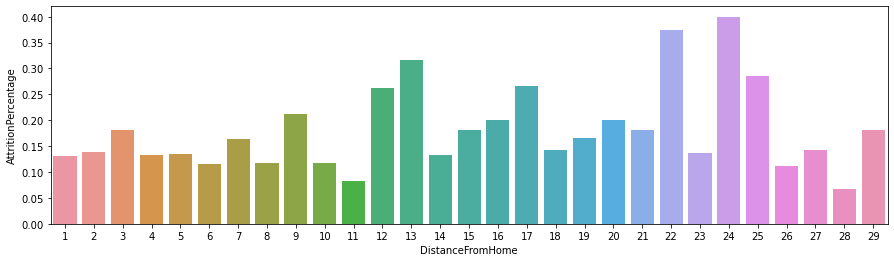

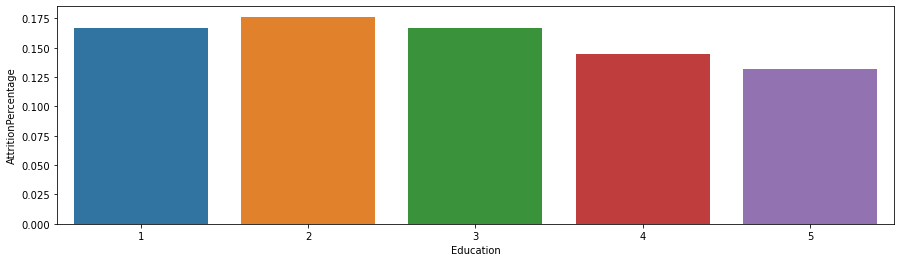

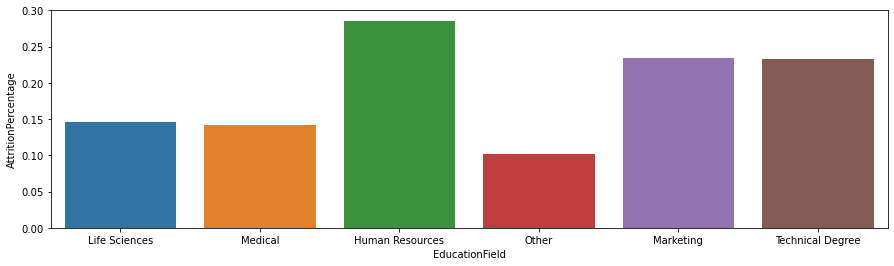

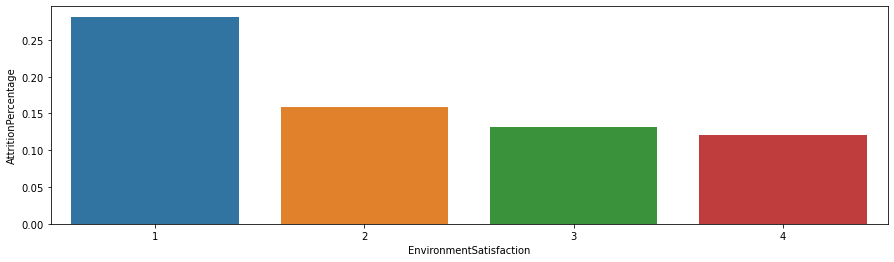

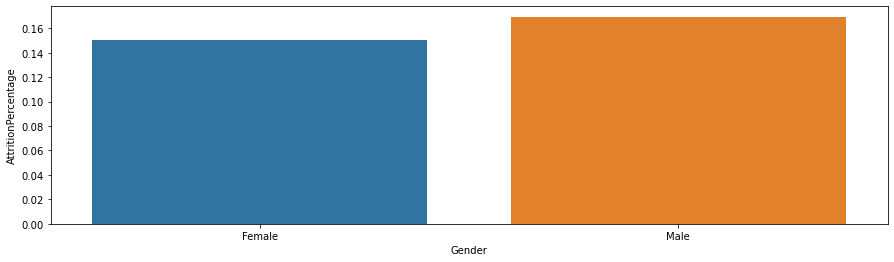

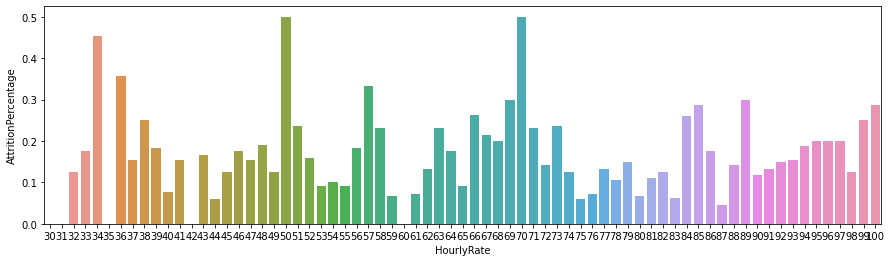

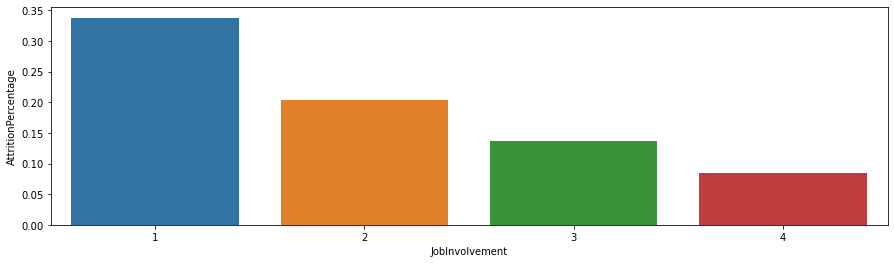

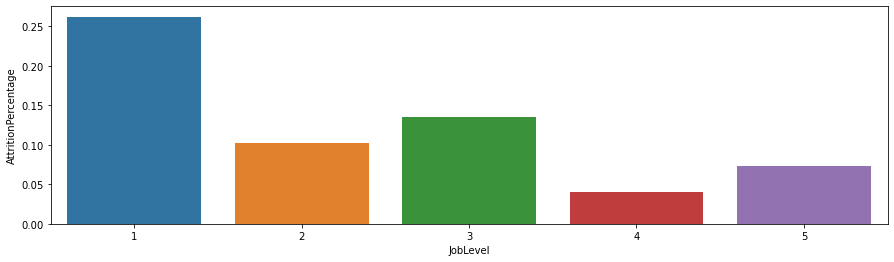

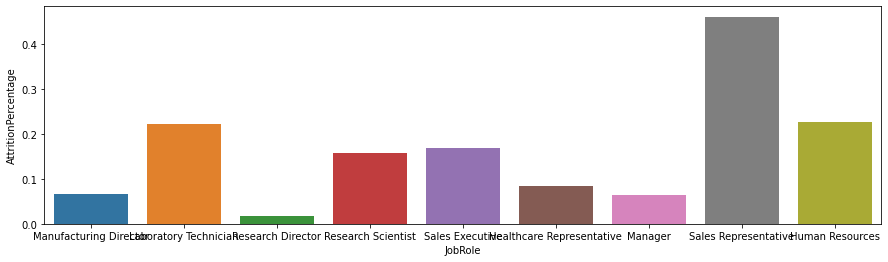

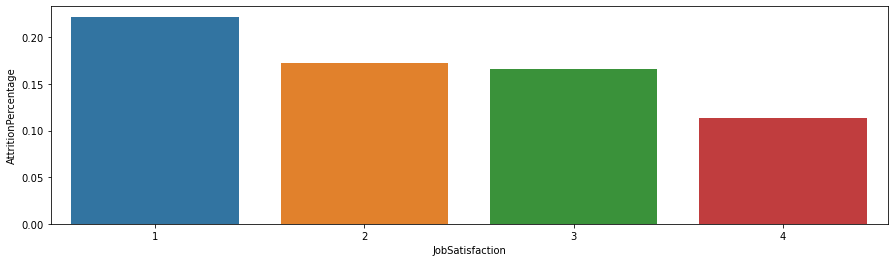

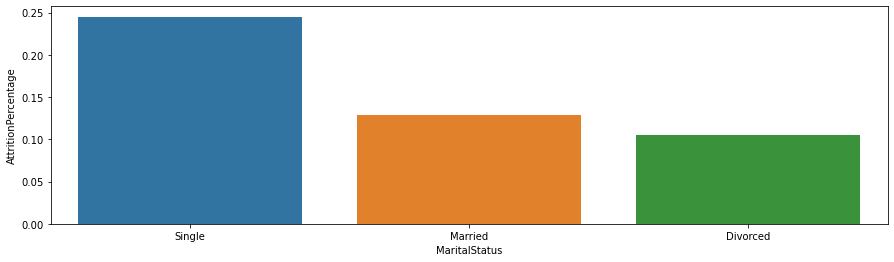

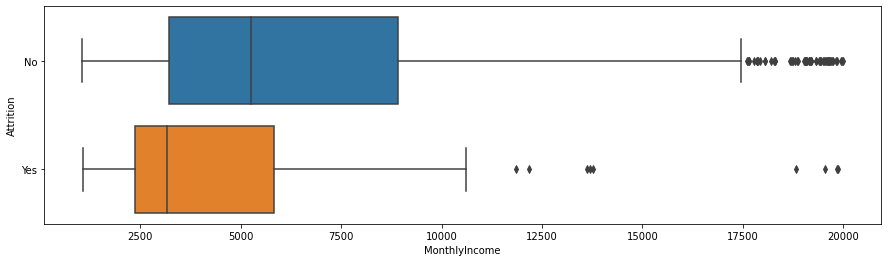

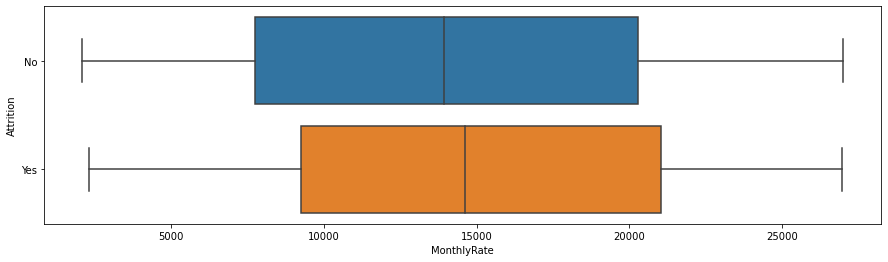

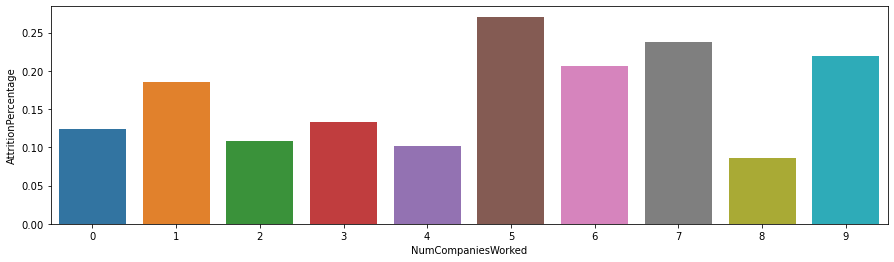

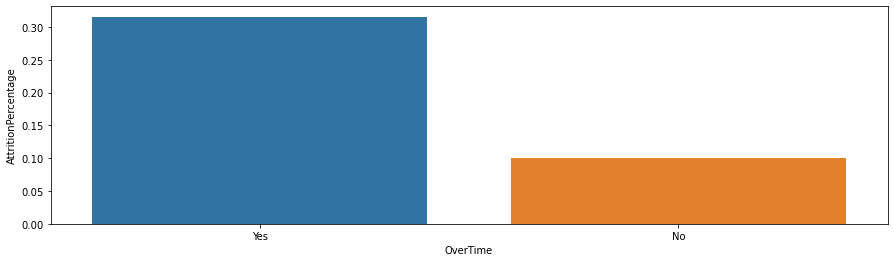

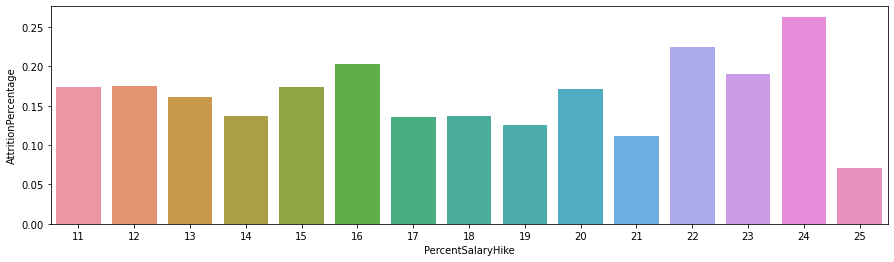

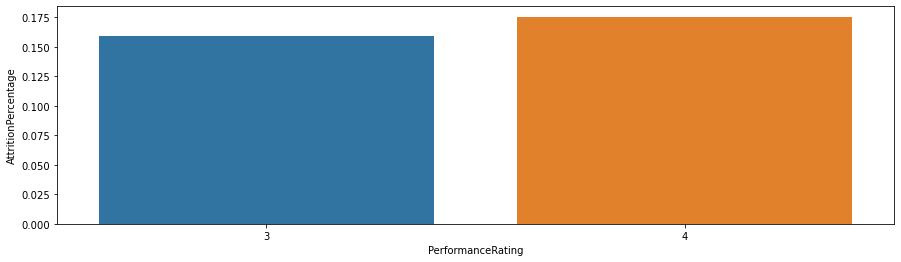

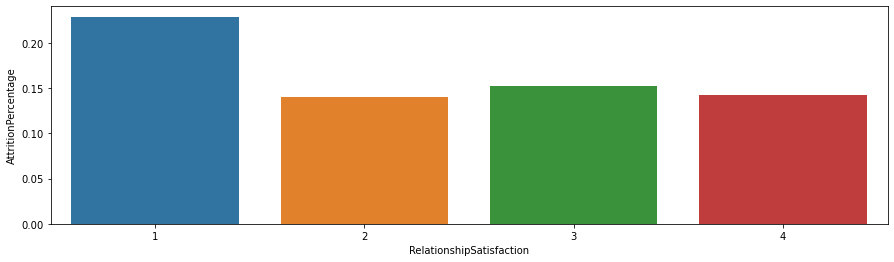

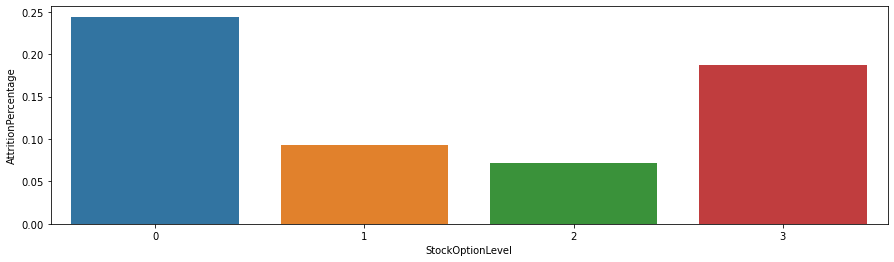

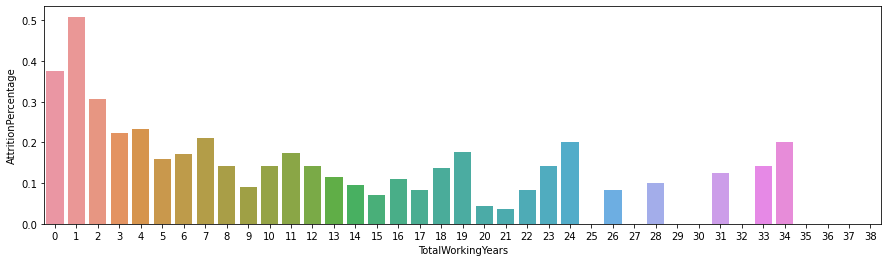

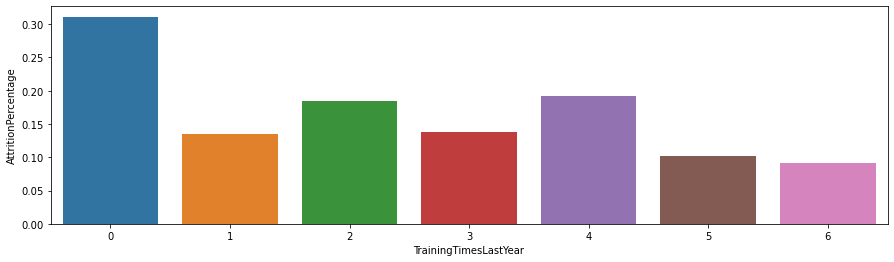

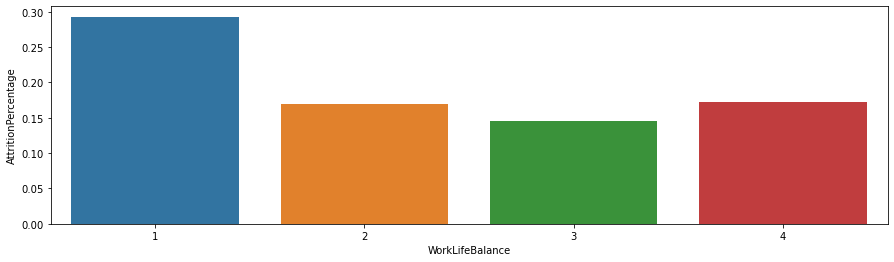

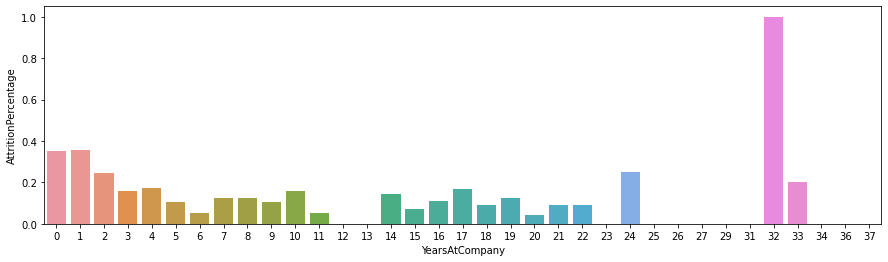

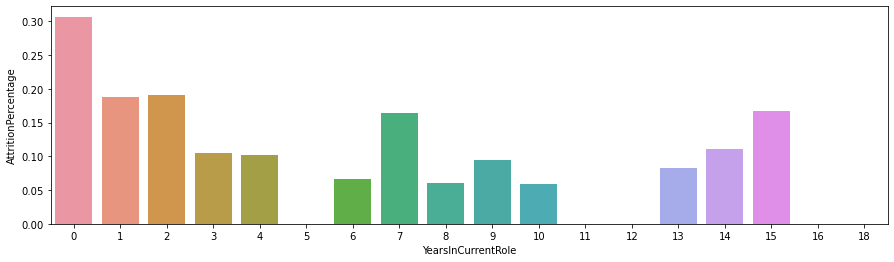

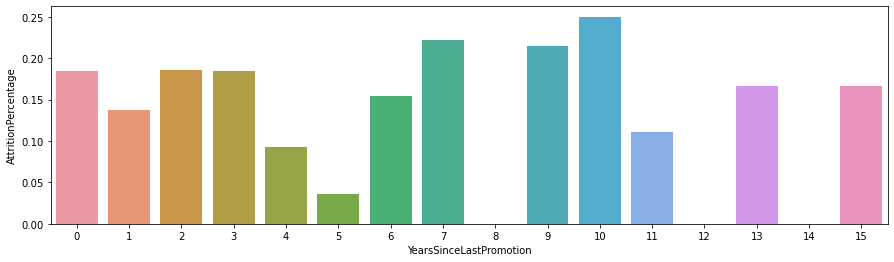

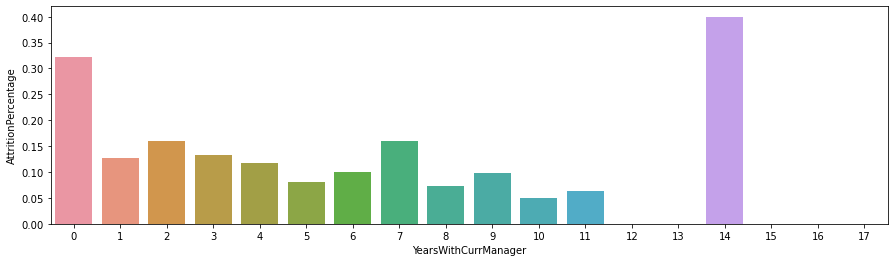

In [569]:
for col in df_train.columns.difference(['Attrition']):
    plt.figure(figsize=(15,4))
    x=list(df_train[col].unique())
    if len(x) > 100:
        ax = sns.boxplot(x=col, y="Attrition", data=df_train)
    else:
        y=[]
        for val in x:
            try:
                y.append(df_train[df_train[col] == val]['Attrition'].value_counts(normalize=True)['Yes'])
            except:
                y.append(1-df_train[df_train[col] == val]['Attrition'].value_counts(normalize=True)['No'])
        sns.barplot(x=x, y=y)
        plt.xlabel(col)
        plt.ylabel('AttritionPercentage')
    # Display the plot
    plt.show()
    # Close the current plot to stop retaining memory
    plt.close()

In [570]:
cols_corr = ['YearsWithCurrManager', 'YearsInCurrentRole', 'WorkLifeBalance', 'TrainingTimesLastYear', 'RelationshipSatisfaction', 'PerformanceRating', 'OverTime', 'NumCompaniesWorked', 'MonthlyRate', 'MonthlyIncome', 'MaritalStatus', 'JobSatisfaction', 'JobRole', 'JobLevel', 'JobInvolvement', 'Gender', 'EnvironmentSatisfaction', 'EducationField', 'Education', 'Department', 'DailyRate', 'BusinessTravel', 'Age']

In [571]:
catg = df_train[cols_corr].select_dtypes(include=[object]).columns.difference(['Attrition'])

print(catg)

Index(['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole',
       'MaritalStatus', 'OverTime'],
      dtype='object')


In [572]:
le = LabelEncoder()

encoded_catg = pd.DataFrame()
for col in catg:
    if len(df_train[col].unique()) <= 2:
        le.fit(df_train[col])
        df_train[col] = le.transform(df_train[col])
    else:
        encoded_catg = pd.concat([encoded_catg, pd.get_dummies(df_train[col], prefix=col)], axis=1)

In [573]:
encoded_catg.head()

,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single
0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0
2,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
3,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
4,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0


In [574]:
catg

Index(['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole',
       'MaritalStatus', 'OverTime'],
      dtype='object')

In [575]:
catg = df_test.select_dtypes(include=[object])
encoded_catg_test = pd.DataFrame()
for col in catg:
    if len(df_test[col].unique()) <= 2:
        le.fit(df_test[col])
        df_test[col] = le.transform(df_test[col])
    else:
        encoded_catg_test = pd.concat([encoded_catg_test, pd.get_dummies(df_test[col], prefix=col)], axis=1)  
Xfinal = pd.concat([df_test.select_dtypes(include=['float64', 'int64']), encoded_catg_test], axis=1)

In [576]:
result={}
result['Metric'] = ('F1_score', 'Auc')

# Logistic Regression

In [577]:
X= pd.concat([df_train.select_dtypes(include=['float64', 'int64']), encoded_catg], axis=1)
y=df_train['Attrition']

In [578]:
from sklearn.feature_selection import RFECV
estimator = LogisticRegression(max_iter=10000, solver="liblinear", penalty='l1')
selector = RFECV(estimator, step=1, cv=5)
selector = selector.fit(X, y)

In [579]:
selector.support_

array([ True,  True,  True,  True,  True,  True,  True,  True, False,
        True, False, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False,  True,  True, False,  True, False,  True,
        True, False,  True,  True, False,  True, False, False, False,
        True, False,  True,  True])

In [580]:
selector.ranking_

array([ 1,  1,  1,  1,  1,  1,  1,  1,  6,  1,  3,  4,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, 14, 12,  1,  1,  5,  1,
        7,  1,  1,  8,  1,  1, 10,  1,  9,  2, 13,  1, 11,  1,  1])

In [581]:
selector.grid_scores_[17]

0.8645454545454545

In [582]:
X.columns

Index(['Age', 'DailyRate', 'DistanceFromHome', 'Education',
       'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement',
       'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate',
       'NumCompaniesWorked', 'OverTime', 'PercentSalaryHike',
       'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager', 'BusinessTravel_Non-Travel',
       'BusinessTravel_Travel_Frequently', 'BusinessTravel_Travel_Rarely',
       'Department_Human Resources', 'Department_Research & Development',
       'Department_Sales', 'EducationField_Human Resources',
       'EducationField_Life Sciences', 'EducationField_Marketing',
       'EducationField_Medical', 'EducationField_Other',
       'EducationField_Technical Degree', 'JobRole_Healthcare Representative',
       'JobRole_Human Resources', 'Jo

In [583]:
RFECV_selected = X.columns[selector.support_]

In [584]:
RFECV_selected

Index(['Age', 'DailyRate', 'DistanceFromHome', 'Education',
       'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement',
       'JobSatisfaction', 'NumCompaniesWorked', 'OverTime',
       'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'BusinessTravel_Non-Travel', 'BusinessTravel_Travel_Frequently',
       'BusinessTravel_Travel_Rarely', 'Department_Sales',
       'EducationField_Human Resources', 'EducationField_Marketing',
       'EducationField_Other', 'EducationField_Technical Degree',
       'JobRole_Human Resources', 'JobRole_Laboratory Technician',
       'JobRole_Manufacturing Director', 'JobRole_Sales Representative',
       'MaritalStatus_Married', 'MaritalStatus_Single'],
      dtype='object')

In [585]:
# from sklearn.feature_selection import f_regression, f_classif, chi2

# K=30
# Xchoice = X
# le.fit(y)
# ychoice = le.transform(y)

# # inputs:
# #    X: pandas.DataFrame, features
# #    y: pandas.Series, target variable
# #    K: number of features to select

# # compute F-statistics and initialize correlation matrix
# F = pd.Series(f_classif(Xchoice, y)[0], index = X.columns)
# corr = pd.DataFrame(.00001, index = X.columns, columns = X.columns)

# # initialize list of selected features and list of excluded features
# selected = []
# not_selected = X.columns.to_list()

# # repeat K times
# for i in range(K):
  
#     # compute (absolute) correlations between the last selected feature and all the (currently) excluded features
#     if i > 0:
#         last_selected = selected[-1]
#         corr.loc[not_selected, last_selected] = X[not_selected].corrwith(X[last_selected]).abs().clip(.00001)
        
#     # compute FCQ score for all the (currently) excluded features (this is Formula 2)
#     score = F.loc[not_selected] / corr.loc[not_selected, selected].mean(axis = 1).fillna(.00001)
    
#     # find best feature, add it to selected and remove it from not_selected
#     best = score.index[score.argmax()]
#     selected.append(best)
#     not_selected.remove(best)

In [586]:
from sklearn.feature_selection import f_regression, f_classif, chi2

K=X.shape[1]
# Xchoice = pd.DataFrame(normalize(X, norm='max', axis=0), columns = X.columns)
Xchoice = X
le.fit(y)
ychoice = le.transform(y)

selection_results = pd.DataFrame(columns=['Explicative_values', 'Explicative_Number', 'F_score', 'Auc'])

# inputs:
#    X: pandas.DataFrame, features
#    y: pandas.Series, target variable
#    K: number of features to select

# compute F-statistics and initialize correlation matrix
F = pd.Series(chi2(Xchoice, y)[0], index = X.columns)
corr = pd.DataFrame(.00001, index = X.columns, columns = X.columns)

# initialize list of selected features and list of excluded features
selected = []
not_selected = X.columns.to_list()

list_selected = []
list_nselected = []
list_f1score = []
list_auc = []
list_attrition = []
list_attrition_train = []

# repeat K times
for i in range(K):
  
    # compute (absolute) correlations between the last selected feature and all the (currently) excluded features
    if i > 0:
        last_selected = selected[-1]
        corr.loc[not_selected, last_selected] = X[not_selected].corrwith(X[last_selected]).abs().clip(.00001)

        
    # compute FCQ score for all the (currently) excluded features (this is Formula 2)
    score = F.loc[not_selected] / corr.loc[not_selected, selected].mean(axis = 1).fillna(.00001)
    
    # find best feature, add it to selected and remove it from not_selected
    best = score.index[score.argmax()]
    selected.append(best)
    not_selected.remove(best)
    X_temp = Xchoice[selected]
    xtrain, xtest, ytrain, ytest = train_test_split(X_temp, y, train_size=0.8, random_state=1)
    model = LogisticRegression(max_iter=50000, solver="liblinear", penalty='l1')
    clf = model.fit(X_temp, y)
    yfinal = clf.predict(Xfinal[selected])
    y_predicted_train = clf.predict(X[selected])
    list_attrition_train.append(1-np.unique(y_predicted_train, return_counts=True)[1][0]/len(y_predicted_train))
    list_selected.append(selected)
    list_nselected.append(i)
    list_f1score.append(np.mean(cross_val_score(model, X_temp, y, cv=5, scoring=f1_scorer)))
    list_auc.append(np.mean(cross_val_score(model, X_temp, y, cv=5, scoring='roc_auc')))
    list_attrition.append(1-np.unique(yfinal, return_counts=True)[1][0]/len(yfinal))

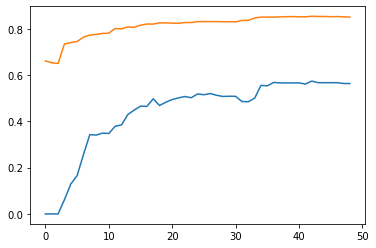

In [587]:
plt.plot(list_nselected, list_f1score)
plt.plot(list_nselected, list_auc);

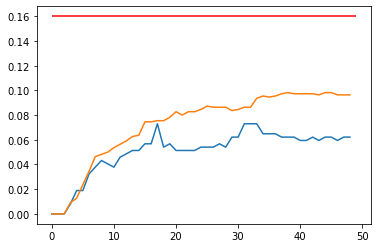

In [588]:
plt.plot(list_nselected, list_attrition)
plt.plot(list_nselected, list_attrition_train)
plt.hlines(0.16, 0, len(list_nselected), color='r')


In [589]:
print(max(list_f1score))
print(list_f1score.index(max(list_f1score)))
print(max(list_auc))
print(list_auc.index(max(list_auc)))
print(list_auc[list_f1score.index(max(list_f1score))])

0.5736523125996811
42
0.8536300710648537
42
0.8536300710648537


In [590]:
f_regression(X, ychoice, center=True)

(array([2.47187423e+01, 3.58326706e+00, 5.21282854e+00, 8.63817348e-01,
        2.24457439e+01, 7.08595944e-01, 5.28137511e-01, 2.70233287e+01,
        3.41625757e+01, 1.12937466e+01, 3.15542667e+01, 7.23595083e-01,
        1.30974368e+00, 8.32280976e+01, 1.76003475e-02, 2.76507679e-01,
        5.18940399e+00, 1.98697639e+01, 3.44407133e+01, 7.96741474e+00,
        3.44830947e+00, 2.45961561e+01, 2.95069628e+01, 1.25024294e+00,
        2.86389648e+01, 7.52278566e+00, 2.14315732e+01, 4.19963676e+00,
        2.28241794e-01, 1.05333367e+01, 9.88912680e+00, 2.42386035e+00,
        1.39463277e+00, 4.78543973e+00, 1.49142188e+00, 1.66103852e+00,
        3.99443558e+00, 4.62839366e+00, 1.44702868e+00, 6.24063268e+00,
        5.74931615e+00, 8.16623752e+00, 1.01442895e+01, 2.66145249e-02,
        8.91282070e-02, 4.56429021e+01, 7.40595369e+00, 7.47848565e+00,
        2.84249992e+01]),
 array([7.69194529e-07, 5.86270412e-02, 2.26112428e-02, 3.52876913e-01,
        2.44486389e-06, 4.00093618e-01

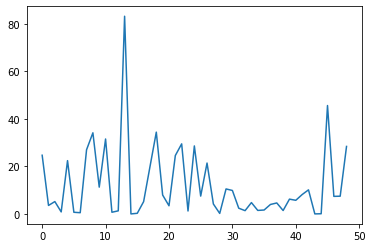

In [591]:
plt.plot(f_regression(X, ychoice, center=True)[0])

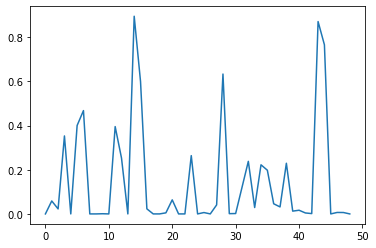

In [592]:
plt.plot(f_regression(X, ychoice, center=True)[1])

In [593]:
f_regression(X, ychoice, center=True)[1]

array([7.69194529e-07, 5.86270412e-02, 2.26112428e-02, 3.52876913e-01,
       2.44486389e-06, 4.00093618e-01, 4.67545843e-01, 2.39595388e-07,
       6.67728665e-09, 8.04445256e-04, 2.45673345e-08, 3.95152641e-01,
       2.52690483e-01, 3.40373885e-19, 8.94481602e-01, 5.99105579e-01,
       2.29165030e-02, 9.14029622e-06, 5.81320396e-09, 4.84866945e-03,
       6.35841430e-02, 8.18564735e-07, 6.85873177e-08, 2.63750657e-01,
       1.06120161e-07, 6.19144934e-03, 4.10442672e-06, 4.06698602e-02,
       6.32925678e-01, 1.20780636e-03, 1.70722178e-03, 1.19788291e-01,
       2.37880031e-01, 2.89116151e-02, 2.22258135e-01, 1.97734635e-01,
       4.58969447e-02, 3.16646078e-02, 2.29264642e-01, 1.26305620e-02,
       1.66612819e-02, 4.34831251e-03, 1.48823790e-03, 8.70438551e-01,
       7.65344887e-01, 2.29722920e-11, 6.60364494e-03, 6.34455628e-03,
       1.18187733e-07])

In [594]:
df_selec = pd.DataFrame(f_regression(X, ychoice, center=True), index = ['F_values', 'p_values'], columns = X.columns)
df_selec.T[df_selec.T['p_values']<=0.05]

,F_values,p_values
Age,24.718742,7.691945e-07
DistanceFromHome,5.212829,2.261124e-02
EnvironmentSatisfaction,22.445744,2.444864e-06
JobInvolvement,27.023329,2.395954e-07
JobLevel,34.162576,6.677287e-09
JobSatisfaction,11.293747,8.044453e-04
MonthlyIncome,31.554267,2.456733e-08
OverTime,83.228098,3.403739e-19
RelationshipSatisfaction,5.189404,2.291650e-02
StockOptionLevel,19.869764,9.140296e-06


In [595]:
X=X[RFECV_selected]
Xfinal=Xfinal[RFECV_selected]

In [596]:
Xnorm = normalize(X, norm='max', axis=0)

In [597]:
pd.DataFrame(Xnorm).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35
count,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000
mean,0.614242,0.536872,0.320752,0.581455,0.682727,0.600909,0.660118,0.676818,0.684318,0.303737,0.288182,0.608764,0.788864,0.674318,0.261818,0.294904,0.463485,0.695227,0.191081,0.236111,0.145758,0.247005,0.109091,0.186364,0.704545,0.305455,0.019091,0.100909,0.053636,0.090000,0.040000,0.176364,0.097273,0.057273,0.452727,0.330000
std,0.150654,0.270750,0.279082,0.202491,0.270891,0.489934,0.203744,0.182825,0.276781,0.281518,0.453122,0.147995,0.090626,0.271084,0.282858,0.204862,0.218229,0.176567,0.166146,0.199727,0.215643,0.210873,0.311895,0.389577,0.456454,0.460809,0.136907,0.301345,0.225401,0.286312,0.196048,0.381303,0.296464,0.232469,0.497987,0.470427
min,0.300000,0.068091,0.034483,0.200000,0.250000,0.000000,0.300000,0.250000,0.250000,0.000000,0.000000,0.440000,0.750000,0.250000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.500000,0.307410,0.068966,0.400000,0.500000,0.000000,0.480000,0.500000,0.500000,0.111111,0.000000,0.480000,0.750000,0.500000,0.000000,0.157895,0.333333,0.500000,0.081081,0.111111,0.000000,0.117647,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.600000,0.537383,0.241379,0.600000,0.750000,1.000000,0.660000,0.750000,0.750000,0.222222,0.000000,0.560000,0.750000,0.750000,0.333333,0.236842,0.500000,0.750000,0.135135,0.166667,0.066667,0.176471,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.704167,0.775701,0.482759,0.800000,1.000000,1.000000,0.840000,0.750000,1.000000,0.444444,1.000000,0.720000,0.750000,1.000000,0.333333,0.394737,0.500000,0.750000,0.243243,0.388889,0.200000,0.411765,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [598]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(X, y, train_size=0.8, random_state=1)

In [599]:
model = LogisticRegression(max_iter=10000, solver="liblinear", penalty='l1')

In [600]:
clf = model.fit(xtrain, ytrain)

In [601]:
f1_scorer = make_scorer(f1_score, pos_label="Yes")

In [602]:
print(np.mean(cross_val_score(clf, Xnorm, y, cv=5, scoring=f1_scorer)))

0.5195297382593208


In [603]:

ytestpred = clf.predict(xtest)

In [604]:
ytest.value_counts()

No     186
Yes     34
Name: Attrition, dtype: int64

In [605]:
ytestpred

array(['No', 'No', 'Yes', 'Yes', 'Yes', 'No', 'No', 'Yes', 'No', 'No',
       'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No',
       'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No',
       'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No',
       'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No',
       'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No',
       'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No',
       'No', 'Yes', 'Yes', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No',
       'No', 'No', 'Yes', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'Yes',
       'No', 'No', 'No', 'No', 'No', 'Yes', 'No', 'No', 'No', 'No', 'No',
       'No', 'No', 'No', 'No', 'Yes', 'No', 'No', 'No', 'Yes', 'No',
       'Yes', 'No', 'No', 'No', 'No', 'No', 'No', 'Yes', 'No', 'No', 'No',
       'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No',
       'No', 'No', 'No', 'No', 'No', 'No', 'No', '

In [606]:
clf.predict_proba(xtest)[:,1]

array([1.29966474e-01, 2.79003718e-02, 5.14000051e-01, 5.19261299e-01,
       6.43156505e-01, 7.18842677e-02, 1.80208501e-01, 6.71250632e-01,
       6.78356873e-02, 9.31294604e-03, 1.80128451e-02, 3.80081954e-01,
       3.14252183e-01, 3.90007145e-01, 2.14150544e-03, 1.88973757e-01,
       1.98882166e-01, 1.13523218e-02, 2.54278474e-02, 3.65936542e-03,
       2.69946783e-02, 5.35513220e-02, 7.16380359e-02, 1.04915918e-02,
       5.73127377e-02, 4.88303133e-02, 4.35109403e-01, 9.01672008e-03,
       7.41824407e-03, 1.62591441e-02, 1.93714749e-01, 4.78772754e-01,
       3.33038862e-02, 1.96855380e-01, 1.87122885e-01, 9.64006340e-02,
       1.97957248e-02, 1.97249409e-02, 8.08398394e-03, 7.61722399e-02,
       5.54815232e-02, 2.46476214e-02, 9.19169851e-02, 6.46862723e-02,
       4.86693181e-02, 2.16085916e-02, 1.68816160e-01, 7.83120831e-02,
       8.94189044e-03, 4.58588438e-02, 1.24391574e-02, 7.03726729e-03,
       3.94487328e-01, 1.54456700e-02, 3.49781917e-02, 3.96107537e-02,
      

In [607]:
f1_score(ytest, ytestpred, pos_label='Yes')

0.6296296296296295

In [608]:
fpr, tpr, thresholds = roc_curve(ytest, clf.predict_proba(xtest)[:,1], pos_label="Yes")
auc(fpr, tpr)

0.9369070208728653

In [609]:
roc_auc_score(ytest, clf.predict_proba(xtest)[:,1])

0.9369070208728653

In [610]:
np.mean(cross_val_score(clf, X, y, cv=5, scoring='roc_auc'))

0.8521749202618768

In [611]:
result['Logistic'] = (np.mean(cross_val_score(clf, X, y, cv=5, scoring=f1_scorer)), np.mean(cross_val_score(clf, X, y, cv=5, scoring='roc_auc')))

f1_score : 0.47058823529411764, params : max_iter=10000, solver="liblinear"

f1_score : 0.48275862068965514, params : max_iter=10000, solver="liblinear", penalty='l1'

In [612]:
ypred = clf.predict(X)

In [613]:
np.unique(ypred)

array(['No', 'Yes'], dtype=object)

In [614]:
yfinal = clf.predict(Xfinal)

In [615]:
unique_elements, counts_elements = np.unique(yfinal, return_counts=True)

In [616]:
unique_elements

array(['No', 'Yes'], dtype=object)

In [617]:
counts_elements

array([349,  21])

In [618]:
df_coef = pd.DataFrame({'colonne': X.columns, 'coeffs':clf.coef_[0], 'coeffs_abs': abs(clf.coef_[0])})
display(df_coef.sort_values(by='coeffs_abs', ascending=False))


,colonne,coeffs,coeffs_abs
10,OverTime,1.842897,1.842897
35,MaritalStatus_Single,1.160441,1.160441
33,JobRole_Sales Representative,1.073939,1.073939
30,JobRole_Human Resources,1.001661,1.001661
31,JobRole_Laboratory Technician,0.879150,0.879150
23,BusinessTravel_Travel_Frequently,0.828280,0.828280
29,EducationField_Technical Degree,0.760486,0.760486
25,Department_Sales,0.703875,0.703875
22,BusinessTravel_Non-Travel,-0.693457,0.693457
7,JobInvolvement,-0.560571,0.560571


In [619]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(clf).fit(xtest, ytest)
eli5.show_weights(perm, feature_names = X.columns.tolist())

Weight,Feature
0.0455 ± 0.0207,OverTime
0.0282 ± 0.0233,TotalWorkingYears
0.0236 ± 0.0233,MaritalStatus_Single
0.0200 ± 0.0169,YearsInCurrentRole
0.0127 ± 0.0134,EnvironmentSatisfaction
0.0118 ± 0.0220,NumCompaniesWorked
0.0100 ± 0.0145,TrainingTimesLastYear
0.0100 ± 0.0121,BusinessTravel_Travel_Frequently
0.0091 ± 0.0207,JobSatisfaction
0.0082 ± 0.0121,JobInvolvement


In [620]:
from pdpbox import pdp, get_dataset, info_plots

# Create the data that we will plot
pdp_attrition = pdp.pdp_isolate(model=clf, dataset=X, model_features=X.columns.tolist(), feature='MonthlyIncome')

# plot it
pdp.pdp_plot(pdp_attrition, 'MonthlyIncome')
plt.show()

ValueError: feature does not exist: MonthlyIncome

In [ ]:
import shap  # package used to calculate Shap values


row_to_show = 80
data_for_prediction = xtest.iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)


print(ytest.iloc[row_to_show])


# Create object that can calculate shap values
explainer = shap.LinearExplainer(clf, xtrain)

# Calculate Shap values
shap_values = explainer.shap_values(xtest)


shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[row_to_show], data_for_prediction)



In [ ]:
shap.summary_plot(shap_values, xtest)

In [ ]:
shap.dependence_plot('MonthlyIncome', shap_values, xtest, interaction_index="OverTime")

In [ ]:
ind=80
explainer = shap.LinearExplainer(model,xtrain)
shap_values = explainer.shap_values(xtest.iloc[ind])

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, xtest.iloc[ind])



In [ ]:
result

{'Metric': ('F1_score', 'Auc'),
 'Logistic': (0.5406599326599326, 0.8320189179863092)} : K=25, f_classif
 result

{'Metric': ('F1_score', 'Auc'),
 'Logistic': (0.48306114898789704, 0.8303836196444893)}: K=15, f_classif

# CART : Decision Tree Regressor

In [755]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier

In [756]:
Xtree= X
y=df_train['Attrition']

In [757]:
# from sklearn.model_selection import train_test_split
# xtrain, xtest, ytrain, ytest = train_test_split(Xtree, y, train_size=0.8)

In [758]:
classifier = DecisionTreeClassifier()
tree_cla = classifier.fit(xtrain, ytrain)

In [759]:
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
ytestpred = tree_cla.predict(xtest)

In [760]:
ytest.value_counts()

No     186
Yes     34
Name: Attrition, dtype: int64

In [761]:
ytestpred

array(['No', 'No', 'Yes', 'No', 'Yes', 'No', 'No', 'No', 'No', 'No', 'No',
       'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No',
       'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No',
       'No', 'No', 'No', 'No', 'No', 'No', 'No', 'Yes', 'No', 'No', 'No',
       'No', 'No', 'No', 'Yes', 'No', 'No', 'No', 'No', 'Yes', 'No', 'No',
       'No', 'No', 'No', 'Yes', 'No', 'No', 'No', 'No', 'Yes', 'No',
       'Yes', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No',
       'No', 'No', 'Yes', 'No', 'No', 'No', 'Yes', 'No', 'No', 'Yes',
       'Yes', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No',
       'No', 'No', 'No', 'No', 'No', 'No', 'Yes', 'Yes', 'No', 'No', 'No',
       'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'Yes', 'No', 'Yes',
       'No', 'No', 'No', 'No', 'No', 'No', 'No', 'Yes', 'No', 'No', 'No',
       'No', 'Yes', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No',
       'No', 'No', 'No', 'No', 'No', 'No', 'N

In [762]:
f1_score(ytest, ytestpred, pos_label='Yes')

0.38805970149253727

In [763]:
fpr, tpr, thresholds = roc_curve(ytest, tree_cla.predict_proba(xtest)[:,1], pos_label="Yes")
auc(fpr, tpr)

0.6374130297280202

In [764]:
roc_auc_score(ytest, tree_cla.predict_proba(xtest)[:,1])

0.6374130297280202

In [765]:
result['CART'] = (np.mean(cross_val_score(tree_cla, X, y, cv=5, scoring=f1_scorer)), np.mean(cross_val_score(tree_cla, X, y, cv=5, scoring='roc_auc')))

f1_score : 0.47058823529411764, params : max_iter=10000, solver="liblinear"

f1_score : 0.48275862068965514, params : max_iter=10000, solver="liblinear", penalty='l1'

In [766]:
ypred = tree_cla.predict(X)

In [767]:
np.unique(ypred)

array(['No', 'Yes'], dtype=object)

In [768]:
yfinal = tree_cla.predict(Xfinal)

In [769]:
unique_elements, counts_elements = np.unique(yfinal, return_counts=True)

In [770]:
unique_elements

array(['No', 'Yes'], dtype=object)

In [771]:
counts_elements

array([300,  70])

In [772]:
tree_cla.feature_importances_

array([0.04922503, 0.04094038, 0.01660628, 0.02486789, 0.01961617,
       0.04906184, 0.0149669 , 0.02649524, 0.01047777, 0.0542052 ,
       0.02422408, 0.01449058, 0.        , 0.01987921, 0.02421749,
       0.04290551, 0.07152598, 0.01401155, 0.02770462, 0.04211579,
       0.07074676, 0.02185505, 0.        , 0.01454717, 0.0276969 ,
       0.        , 0.00486632, 0.03867707, 0.01299509, 0.08370679,
       0.00694642, 0.        , 0.00553543, 0.        , 0.0308317 ,
       0.03632624, 0.        , 0.00851604, 0.        , 0.        ,
       0.        , 0.00952225, 0.00512696, 0.        , 0.01112385,
       0.        , 0.        , 0.00468151, 0.00092718, 0.        ,
       0.        , 0.        , 0.00366315, 0.        , 0.01076443,
       0.        , 0.00340617, 0.        , 0.        , 0.        ])

In [773]:
Xtree.columns

Index(['Age', 'Age-TotalWorkingYears', 'DailyRate', 'DaysWorkedPerYear',
       'DaysWorkedPerYear2', 'DistanceFromHome', 'Education',
       'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'HoursWorkedPerDay',
       'JobInvolvement', 'JobLevel', 'JobLevelDividedByAge', 'JobSatisfaction',
       'MTotalWorkingYearsByMonthlyIncome', 'MonthlyIncome',
       'MonthlyIncomeDividedByAge', 'MonthlyRate', 'NumCompaniesWorked',
       'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears',
       'TotalWorkingYears*JobLevel', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'WorkingYearsDividedByAge', 'YearsAtCompany',
       'YearsAtCompany*JobLevel', 'YearsAtCompanyDividedByMonthlyIncome',
       'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'BusinessTravel_Non-Travel', 'BusinessTravel_Travel_Frequently',
       'BusinessTravel_Travel_Rarely', 'Department_Human Resources',
      

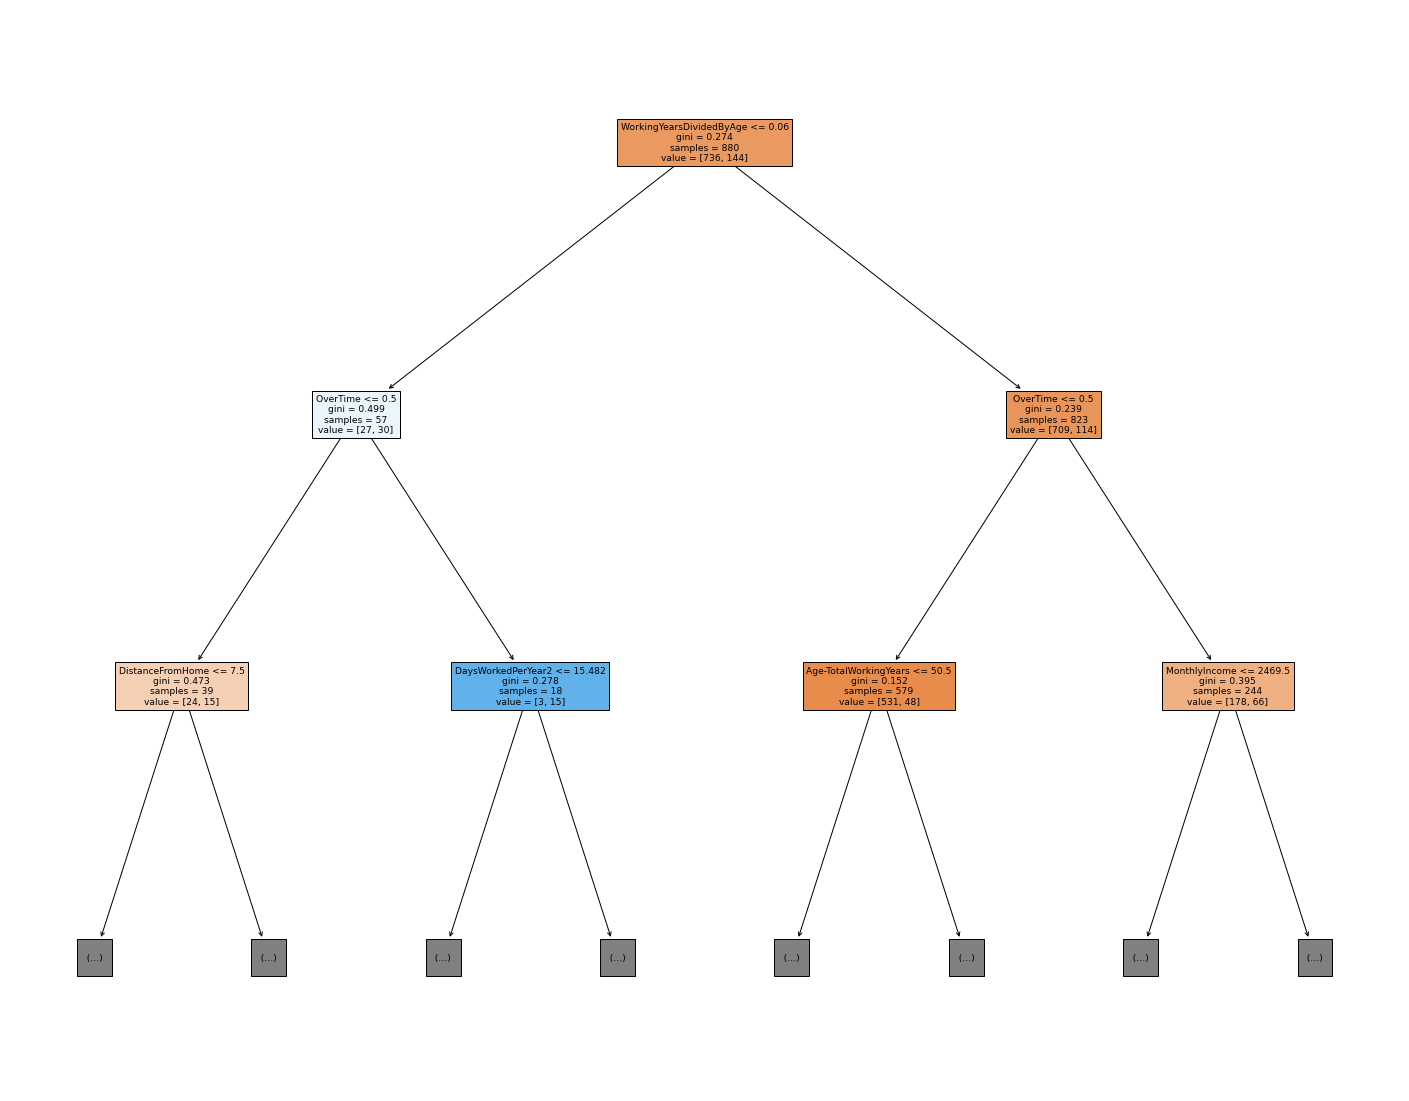

In [774]:
from sklearn.tree import plot_tree
fig = plt.figure(figsize=(25,20))
_ = plot_tree(decision_tree = tree_cla,
              feature_names = Xtree.columns,
                   filled=True, max_depth=2)

In [775]:
perm = PermutationImportance(tree_cla).fit(xtest, ytest)
eli5.show_weights(perm, feature_names = X.columns.tolist())

Weight,Feature
0.0445 ± 0.0210,OverTime
0.0309 ± 0.0266,TotalWorkingYears*JobLevel
0.0300 ± 0.0397,WorkingYearsDividedByAge
0.0264 ± 0.0247,EnvironmentSatisfaction
0.0118 ± 0.0248,MonthlyIncome
0.0100 ± 0.0156,TrainingTimesLastYear
0.0082 ± 0.0145,YearsWithCurrManager
0.0082 ± 0.0068,JobSatisfaction
0.0073 ± 0.0148,HourlyRate
0.0045 ± 0.0057,Education


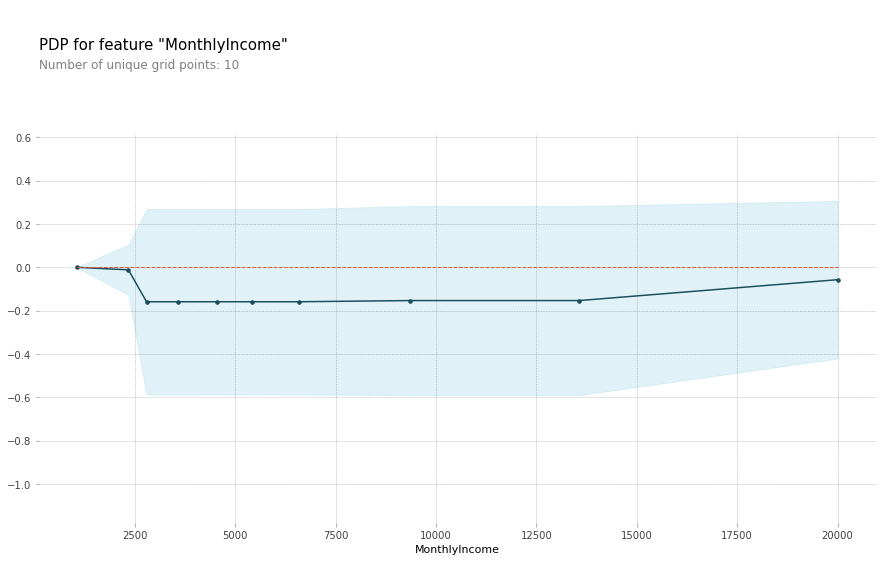

In [828]:
# Create the data that we will plot
pdp_attrition = pdp.pdp_isolate(model=tree_cla, dataset=X, model_features=X.columns.tolist(), feature='MonthlyIncome')

# plot it
pdp.pdp_plot(pdp_attrition, 'MonthlyIncome')
plt.show()

In [776]:
import shap  # package used to calculate Shap values


row_to_show = 80
data_for_prediction = xtest.iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)


print(ytest.iloc[row_to_show])


# Create object that can calculate shap values
explainer = shap.TreeExplainer(tree_cla)

# Calculate Shap values
shap_values = explainer.shap_values(xtest)

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][row_to_show], data_for_prediction)



No


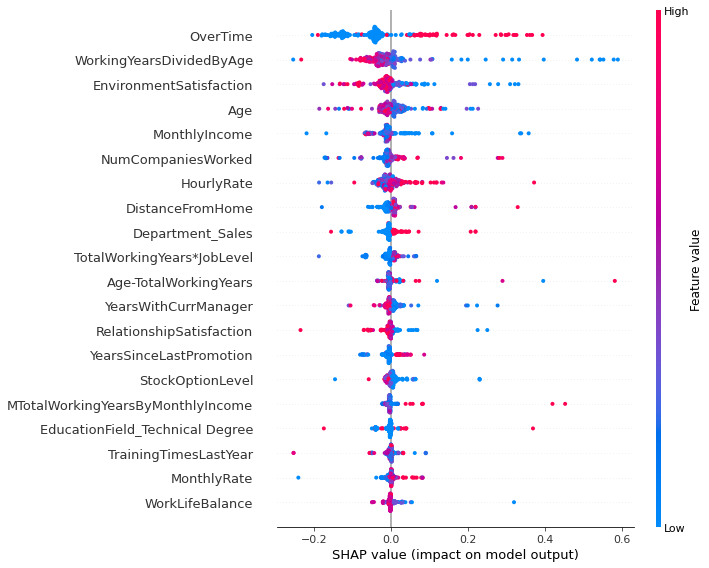

In [777]:
shap.summary_plot(shap_values[1], xtest)

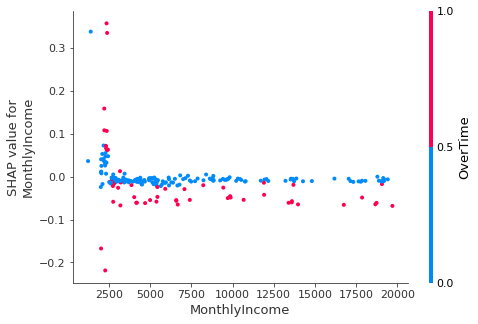

In [778]:
shap.dependence_plot('MonthlyIncome', shap_values[1], xtest, interaction_index="OverTime")

In [281]:
from scipy.stats import f, t, ttest_ind
# Import de fisher et student et p-value

f_log = f.ppf(0.01, 29, 18)
f_log



0.38084718434477144

# RandomForest

In [779]:
from sklearn.ensemble import RandomForestClassifier

In [780]:
Xforest = X
y=df_train['Attrition']

In [781]:
# from sklearn.model_selection import train_test_split
# xtrain, xtest, ytrain, ytest = train_test_split(Xforest, y, train_size=0.8)

In [782]:
forest_classifier = RandomForestClassifier()
forest = forest_classifier.fit(xtrain, ytrain)

In [783]:
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
ytestpred = forest.predict(xtest)

In [784]:
ytest.value_counts()

No     186
Yes     34
Name: Attrition, dtype: int64

In [785]:
ytestpred

array(['No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No',
       'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No',
       'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No',
       'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No',
       'No', 'No', 'No', 'Yes', 'No', 'No', 'No', 'No', 'Yes', 'No', 'No',
       'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No',
       'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No',
       'No', 'Yes', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No',
       'No', 'Yes', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No',
       'No', 'No', 'No', 'No', 'Yes', 'No', 'No', 'No', 'No', 'No', 'No',
       'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No',
       'No', 'No', 'No', 'No', 'No', 'Yes', 'No', 'No', 'No', 'No', 'No',
       'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No',
       'No', 'No', 'No', 'No', 'No', 'No', 'Y

In [786]:
f1_score(ytest, ytestpred, pos_label='Yes')

0.2857142857142857

In [787]:
fpr, tpr, thresholds = roc_curve(ytest, forest.predict_proba(xtest)[:,1], pos_label="Yes")
auc(fpr, tpr)

0.868674889310563

In [788]:
roc_auc_score(ytest, forest.predict_proba(xtest)[:,1])

0.868674889310563

In [789]:
result['RandomForest'] = (np.mean(cross_val_score(forest, X, y, cv=5, scoring=f1_scorer)), np.mean(cross_val_score(forest, X, y, cv=5, scoring='roc_auc')))

f1_score : 0.47058823529411764, params : max_iter=10000, solver="liblinear"

f1_score : 0.48275862068965514, params : max_iter=10000, solver="liblinear", penalty='l1'

In [790]:
ypred = forest.predict(X)

In [791]:
np.unique(ypred)

array(['No', 'Yes'], dtype=object)

In [792]:
yfinal = forest.predict(Xfinal)

In [793]:
unique_elements, counts_elements = np.unique(yfinal, return_counts=True)

In [794]:
unique_elements

array(['No', 'Yes'], dtype=object)

In [795]:
counts_elements

array([359,  11])

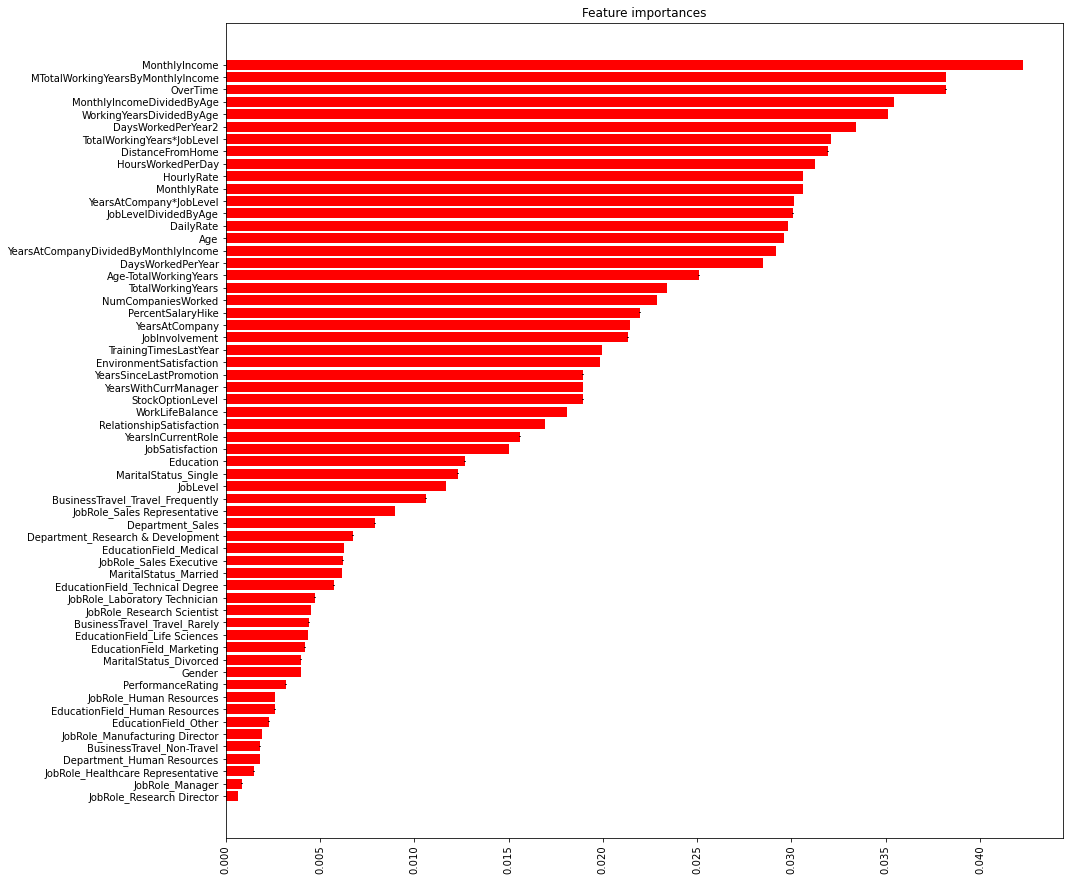

In [796]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]


xforest=[]
yforest=[]

for f in range(X.shape[1]-1, -1, -1):
#     print("{} : {} : {}".format(f + 1, Xforest.columns[indices[f]], importances[indices[f]]))
    xforest.append(Xforest.columns[indices[f]])
    yforest.append(importances[indices[f]])

# Plot the impurity-based feature importances of the forest
plt.figure(figsize=(15,15))
plt.title("Feature importances")
plt.barh(xforest, yforest, yerr=std[indices],
        color="r")
plt.xticks(rotation=90)
plt.show()

In [797]:
perm = PermutationImportance(forest).fit(xtest, ytest)
eli5.show_weights(perm, feature_names = X.columns.tolist())

Weight,Feature
0.0109 ± 0.0123,OverTime
0.0100 ± 0.0036,Age
0.0091 ± 0.0057,YearsAtCompany
0.0082 ± 0.0089,YearsAtCompanyDividedByMonthlyIncome
0.0073 ± 0.0073,JobLevel
0.0073 ± 0.0109,YearsAtCompany*JobLevel
0.0064 ± 0.0073,RelationshipSatisfaction
0.0064 ± 0.0045,BusinessTravel_Travel_Frequently
0.0064 ± 0.0045,YearsInCurrentRole
0.0064 ± 0.0093,HoursWorkedPerDay


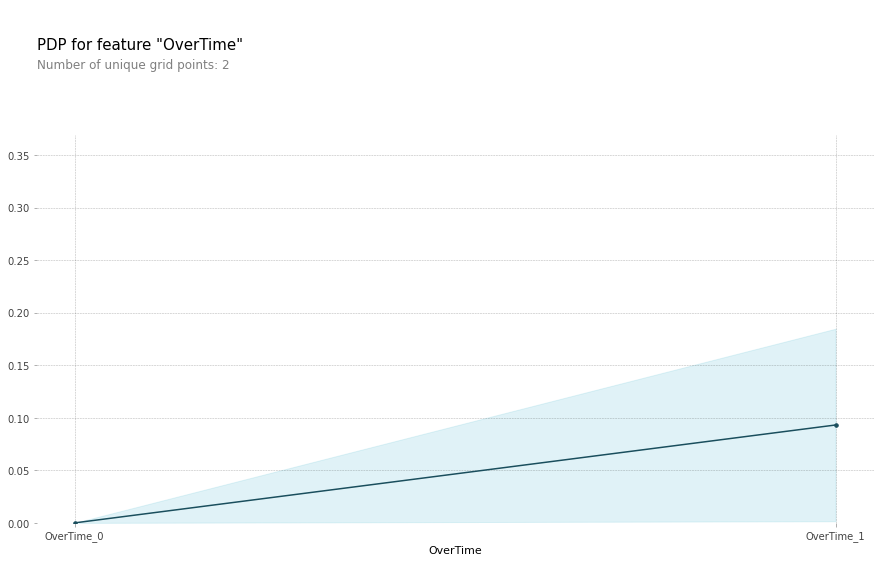

In [798]:
# Create the data that we will plot
pdp_attrition = pdp.pdp_isolate(model=forest, dataset=X, model_features=X.columns.tolist(), feature='OverTime')

# plot it
pdp.pdp_plot(pdp_attrition, 'OverTime')
plt.show()

In [799]:
import shap  # package used to calculate Shap values


row_to_show = 80
data_for_prediction = xtest.iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)


print(ytest.iloc[row_to_show])
print(forest.predict(xtest)[row_to_show])


# Create object that can calculate shap values
explainer = shap.TreeExplainer(forest)

# Calculate Shap values
shap_values = explainer.shap_values(xtest)


shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][row_to_show], data_for_prediction)



No
No


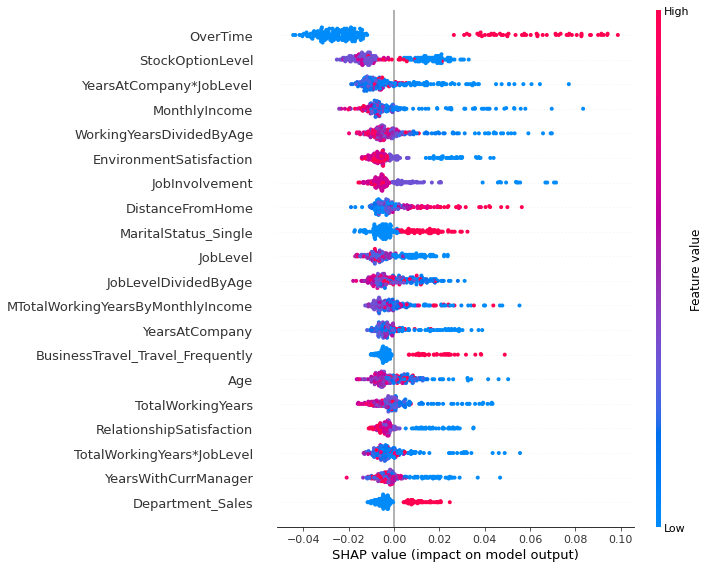

In [800]:
shap.summary_plot(shap_values[1], xtest)

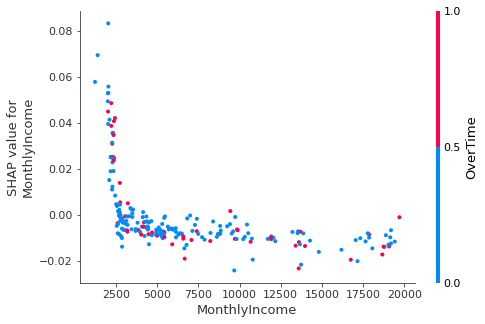

In [801]:
shap.dependence_plot('MonthlyIncome', shap_values[1], xtest, interaction_index="OverTime")

# Xgboost

In [802]:
import xgboost as xgb

In [803]:
# Xxgb = df_train[df_train.columns.difference(['Attrition'])]
# catg = Xxgb.select_dtypes(include=[object])
# for col in catg:
#     le.fit(Xxgb[col])
#     Xxgb[col] = le.transform(Xxgb[col]) 
Xxgb = X
y = df_train['Attrition']

In [804]:
# from sklearn.model_selection import train_test_split
# xtrain, xtest, ytrain, ytest = train_test_split(Xxgb, y, train_size=0.8)

In [805]:
xgb_model = xgb.XGBClassifier()
xgb_fit = xgb_model.fit(xtrain, ytrain)

[14:02:53] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [806]:
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
ytestpred = xgb_fit.predict(xtest)

In [807]:
ytest.value_counts()

No     186
Yes     34
Name: Attrition, dtype: int64

In [808]:
ytestpred

array(['No', 'No', 'No', 'No', 'Yes', 'No', 'No', 'No', 'No', 'No', 'No',
       'No', 'Yes', 'Yes', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No',
       'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'Yes', 'No',
       'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No',
       'No', 'No', 'No', 'Yes', 'No', 'No', 'No', 'No', 'Yes', 'No', 'No',
       'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'Yes',
       'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No',
       'Yes', 'Yes', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No',
       'No', 'Yes', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No',
       'No', 'No', 'No', 'No', 'Yes', 'No', 'No', 'No', 'No', 'No', 'No',
       'No', 'No', 'No', 'Yes', 'No', 'No', 'No', 'No', 'No', 'Yes', 'No',
       'No', 'No', 'No', 'No', 'No', 'Yes', 'No', 'No', 'No', 'No', 'No',
       'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No',
       'No', 'No', 'No', 'No', 'No', 

In [809]:
f1_score(ytest, ytestpred, pos_label='Yes')

0.5098039215686274

In [810]:
fpr, tpr, thresholds = roc_curve(ytest, xgb_fit.predict_proba(xtest)[:,1], pos_label="Yes")
auc(fpr, tpr)

0.8896268184693232

In [811]:
roc_auc_score(ytest, xgb_fit.predict_proba(xtest)[:,1])

0.8896268184693232

In [812]:
result['Xgboost'] = (np.mean(cross_val_score(xgb_fit, X, y, cv=5, scoring=f1_scorer)), np.mean(cross_val_score(xgb_fit, X, y, cv=5, scoring='roc_auc')))

[14:02:54] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:02:54] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:02:54] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:02:54] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

f1_score : 0.47058823529411764, params : max_iter=10000, solver="liblinear"

f1_score : 0.48275862068965514, params : max_iter=10000, solver="liblinear", penalty='l1'

In [813]:
ypred = xgb_fit.predict(X)

In [814]:
np.unique(ypred)

array(['No', 'Yes'], dtype=object)

In [815]:
yfinal = xgb_fit.predict(Xfinal)

In [816]:
unique_elements, counts_elements = np.unique(yfinal, return_counts=True)

In [817]:
unique_elements

array(['No', 'Yes'], dtype=object)

In [818]:
counts_elements

array([346,  24])

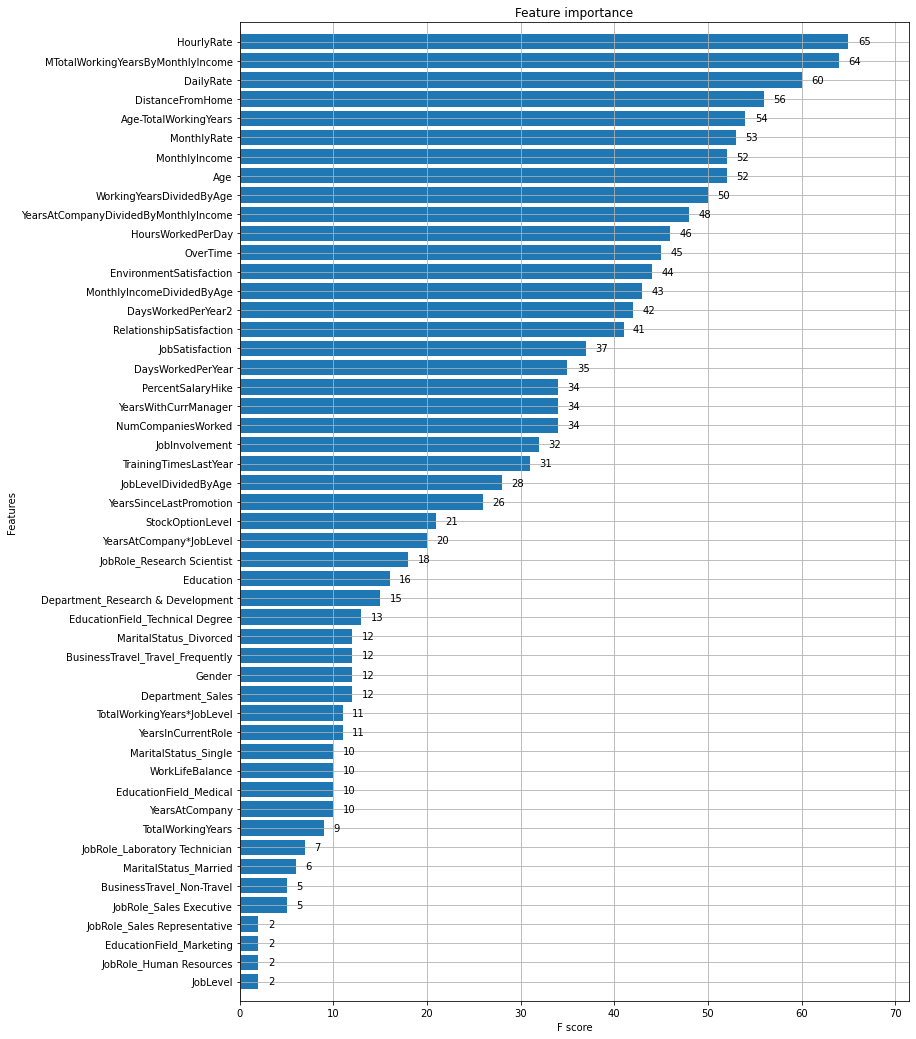

In [819]:
# plot the important features #
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(xgb_fit, max_num_features=50, height=0.8, ax=ax)
plt.show()

In [820]:
perm = PermutationImportance(xgb_fit).fit(xtest, ytest)
eli5.show_weights(perm, feature_names = X.columns.tolist())

Weight,Feature
0.0391 ± 0.0297,OverTime
0.0091 ± 0.0100,StockOptionLevel
0.0073 ± 0.0073,JobSatisfaction
0.0064 ± 0.0073,EnvironmentSatisfaction
0.0064 ± 0.0045,RelationshipSatisfaction
0.0045 ± 0.0000,TotalWorkingYears
0.0018 ± 0.0123,TrainingTimesLastYear
0.0009 ± 0.0068,NumCompaniesWorked
0.0009 ± 0.0036,YearsAtCompany
0 ± 0.0000,BusinessTravel_Travel_Rarely


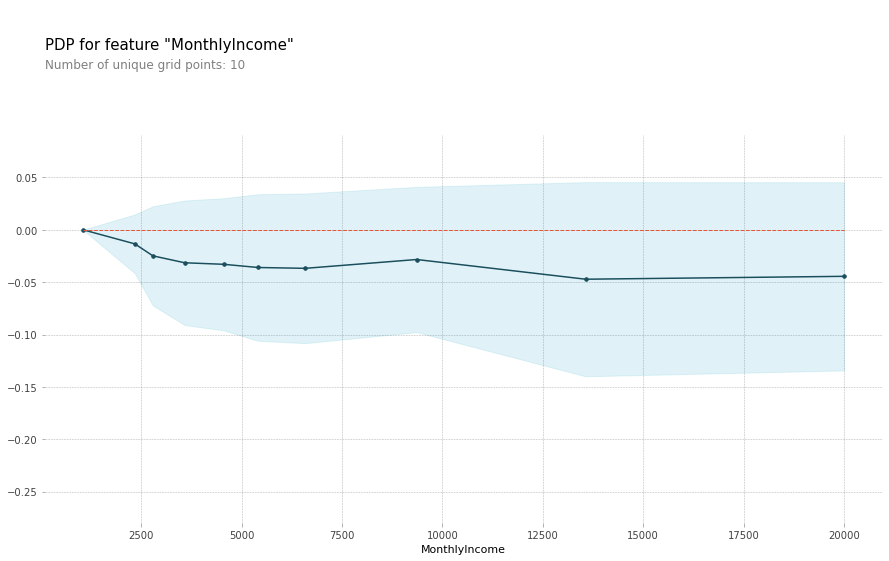

In [821]:
from pdpbox import pdp, get_dataset, info_plots

# Create the data that we will plot
pdp_attrition = pdp.pdp_isolate(model=xgb_fit, dataset=X, model_features=X.columns.tolist(), feature='MonthlyIncome')

# plot it
pdp.pdp_plot(pdp_attrition, 'MonthlyIncome')
plt.show()


In [822]:
import shap  # package used to calculate Shap values


row_to_show = 80
data_for_prediction = xtest.iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)


print(ytest.iloc[row_to_show])

# Create object that can calculate shap values
explainer = shap.TreeExplainer(xgb_fit, xtest)

# Calculate Shap values
shap_values = explainer.shap_values(xtest)

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[row_to_show], data_for_prediction)



No


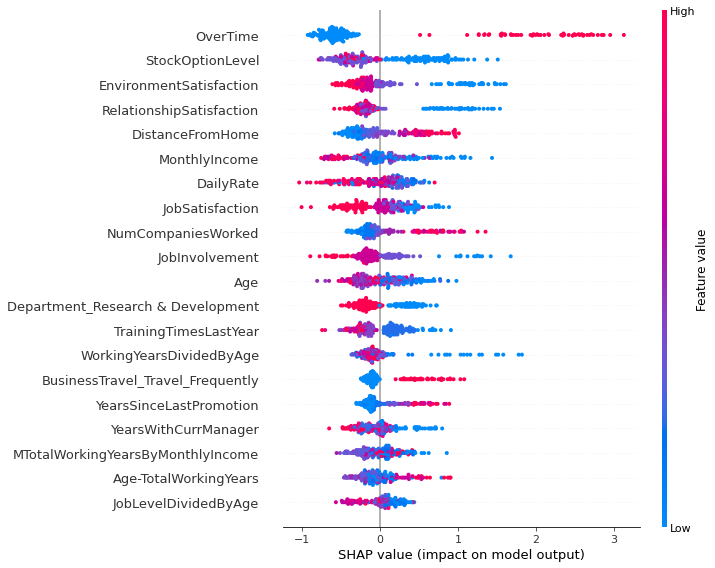

In [823]:
shap.summary_plot(shap_values, xtest)

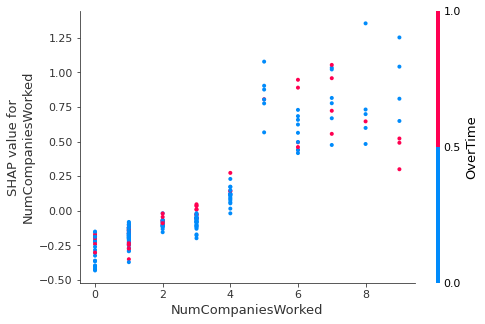

In [824]:
shap.dependence_plot('NumCompaniesWorked', shap_values, xtest, interaction_index="OverTime")

In [492]:
result

{'Logistic': (0.5771515611894475, 0.8463277936321415),
 'CART': (0.34140092876379713, 0.6217117583421932),
 'RandomForest': (0.23076066790352506, 0.780462115065376),
 'Xgboost': (0.4057468457468458, 0.7858964896573593)}

In [493]:
pd.DataFrame(result)

,Logistic,CART,RandomForest,Xgboost
0,0.577152,0.341401,0.230761,0.405747
1,0.846328,0.621712,0.780462,0.785896


In [118]:
X2=X[relevant_coef]
y=df_train['Attrition']

In [119]:
y.shape

(1100,)

In [120]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
x2train, x2test, y2train, y2test = train_test_split(X2, y, train_size=0.8)

In [121]:
model = LogisticRegression(max_iter=10000, solver="liblinear", penalty='l1')

In [122]:
clf = model.fit(x2train, y2train)

In [123]:
from sklearn.metrics import f1_score
ytestpred = clf.predict(x2test)

In [124]:
ytest.value_counts()

No     186
Yes     34
Name: Attrition, dtype: int64

In [125]:
ytestpred

array(['No', 'Yes', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No',
       'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No',
       'No', 'No', 'No', 'No', 'No', 'Yes', 'No', 'No', 'Yes', 'No', 'No',
       'Yes', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No',
       'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No',
       'No', 'No', 'No', 'No', 'No', 'No', 'No', 'Yes', 'No', 'No', 'No',
       'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No',
       'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'Yes',
       'No', 'Yes', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No',
       'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No',
       'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No',
       'No', 'No', 'No', 'No', 'No', 'No', 'Yes', 'No', 'No', 'No', 'No',
       'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No',
       'No', 'No', 'Yes', 'No', 'No', 'No',

In [126]:
clf.predict_proba(x2test)

array([[0.9937334 , 0.0062666 ],
       [0.42409151, 0.57590849],
       [0.98762757, 0.01237243],
       [0.93362086, 0.06637914],
       [0.58964207, 0.41035793],
       [0.81063121, 0.18936879],
       [0.85138792, 0.14861208],
       [0.92573476, 0.07426524],
       [0.87263909, 0.12736091],
       [0.98383371, 0.01616629],
       [0.98744522, 0.01255478],
       [0.97967663, 0.02032337],
       [0.89059583, 0.10940417],
       [0.94440837, 0.05559163],
       [0.95580854, 0.04419146],
       [0.96241667, 0.03758333],
       [0.98577615, 0.01422385],
       [0.84526798, 0.15473202],
       [0.9045783 , 0.0954217 ],
       [0.99557259, 0.00442741],
       [0.95352401, 0.04647599],
       [0.98557975, 0.01442025],
       [0.83451589, 0.16548411],
       [0.95683103, 0.04316897],
       [0.77577692, 0.22422308],
       [0.65953182, 0.34046818],
       [0.99031291, 0.00968709],
       [0.38769916, 0.61230084],
       [0.88407505, 0.11592495],
       [0.93941607, 0.06058393],
       [0.

In [127]:
f1_score(ytest, ytestpred, pos_label='Yes')

0.15686274509803924

f1_score : 0.47058823529411764, params : max_iter=10000, solver="liblinear"

f1_score : 0.48275862068965514, params : max_iter=10000, solver="liblinear", penalty='l1'

In [128]:
ypred = clf.predict(X2)

In [129]:
np.unique(ypred)

array(['No', 'Yes'], dtype=object)

In [130]:
df_coef = pd.DataFrame({'colonne': X2.columns, 'coeffs':clf.coef_[0], 'coeffs_abs': abs(clf.coef_[0])})
display(df_coef.sort_values(by='coeffs_abs', ascending=False))


,colonne,coeffs,coeffs_abs
0,OverTime,1.847406,1.847406
4,JobRole_Sales Representative,1.745390,1.745390
7,JobRole_Laboratory Technician,1.352515,1.352515
2,BusinessTravel_Travel_Frequently,1.104468,1.104468
1,JobRole_Human Resources,0.925938,0.925938
6,MaritalStatus_Single,0.838174,0.838174
5,Department_Sales,0.740843,0.740843
14,EducationField_Human Resources,0.679723,0.679723
8,BusinessTravel_Non-Travel,-0.583756,0.583756
12,Gender,0.558485,0.558485
